# Afriat

In [1]:
ood_seed = 8

In [2]:
num_ood = 1  # not functioning

In [3]:
obs_key = "status_control"

In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0.0', 'Pericentral', 'Control'),
  ('0.0', 'Periportal', 'Control'),
  ('12.0', 'Pericentral', 'Infected'),
  ('12.0', 'Pericentral', 'Uninfected'),
  ('12.0', 'Periportal', 'Infected'),
  ('12.0', 'Periportal', 'Uninfected'),
  ('2.0', 'Pericentral', 'Uninfected'),
  ('2.0', 'Periportal', 'Infected'),
  ('2.0', 'Periportal', 'Uninfected'),
  ('24.0', 'Pericentral', 'Infected'),
  ('24.0', 'Pericentral', 'Uninfected'),
  ('24.0', 'Periportal', 'Infected'),
  ('24.0', 'Periportal', 'Uninfected'),
  ('30.0', 'Pericentral', 'Infected'),
  ('30.0', 'Pericentral', 'Uninfected'),
  ('30.0', 'Periportal', 'Infected'),
  ('30.0', 'Periportal', 'Uninfected'),
  ('36.0', 'Pericentral', 'Infected'),
  ('36.0', 'Pericentral', 'Uninfected'),
  ('36.0', 'Periportal', 'Infected'),
  ('36.0', 'Periportal', 'Uninfected')],
 21)

In [8]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

('2.0', 'Periportal', 'Uninfected')

Removed datapoint: 1330


In [9]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
]

In [10]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates = True,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=None,
    model_level_metrics_helper_covariates=None
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: fdrbdkhm
Name: rebel-tauntaun-478
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/fdrbdkhm
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_142612-fdrbdkhm/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `training` set. Number of elements in each group: 2560,3300,8319
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `validation` set. Number of elements in each group: 645,809,2090
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:06<1:08:06,  6.82s/it]

Epoch 1/600:   0%|          | 1/600 [00:06<1:08:06,  6.82s/it, v_num=hm_1, total_loss_train=3.72e+3, kl_local_train=43.5]

Epoch 2/600:   0%|          | 1/600 [00:06<1:08:06,  6.82s/it, v_num=hm_1, total_loss_train=3.72e+3, kl_local_train=43.5]

Epoch 2/600:   0%|          | 2/600 [00:13<1:04:31,  6.47s/it, v_num=hm_1, total_loss_train=3.72e+3, kl_local_train=43.5]

Epoch 2/600:   0%|          | 2/600 [00:13<1:04:31,  6.47s/it, v_num=hm_1, total_loss_train=3.22e+3, kl_local_train=69.2]

Epoch 3/600:   0%|          | 2/600 [00:13<1:04:31,  6.47s/it, v_num=hm_1, total_loss_train=3.22e+3, kl_local_train=69.2]

Epoch 3/600:   0%|          | 3/600 [00:19<1:03:25,  6.37s/it, v_num=hm_1, total_loss_train=3.22e+3, kl_local_train=69.2]

Epoch 3/600:   0%|          | 3/600 [00:19<1:03:25,  6.37s/it, v_num=hm_1, total_loss_train=3.2e+3, kl_local_train=72.2] 

Epoch 4/600:   0%|          | 3/600 [00:19<1:03:25,  6.37s/it, v_num=hm_1, total_loss_train=3.2e+3, kl_local_train=72.2]

Epoch 4/600:   1%|          | 4/600 [00:25<1:02:49,  6.32s/it, v_num=hm_1, total_loss_train=3.2e+3, kl_local_train=72.2]

Epoch 4/600:   1%|          | 4/600 [00:25<1:02:49,  6.32s/it, v_num=hm_1, total_loss_train=3.2e+3, kl_local_train=71.2]

Epoch 5/600:   1%|          | 4/600 [00:25<1:02:49,  6.32s/it, v_num=hm_1, total_loss_train=3.2e+3, kl_local_train=71.2]

Epoch 5/600:   1%|          | 5/600 [00:31<1:02:18,  6.28s/it, v_num=hm_1, total_loss_train=3.2e+3, kl_local_train=71.2]

Epoch 5/600:   1%|          | 5/600 [00:31<1:02:18,  6.28s/it, v_num=hm_1, total_loss_train=3.2e+3, kl_local_train=67.5]

Epoch 6/600:   1%|          | 5/600 [00:31<1:02:18,  6.28s/it, v_num=hm_1, total_loss_train=3.2e+3, kl_local_train=67.5]

Epoch 6/600:   1%|          | 6/600 [00:37<1:02:01,  6.27s/it, v_num=hm_1, total_loss_train=3.2e+3, kl_local_train=67.5]

Epoch 6/600:   1%|          | 6/600 [00:37<1:02:01,  6.27s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=61.3]

Epoch 7/600:   1%|          | 6/600 [00:38<1:02:01,  6.27s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=61.3]

Epoch 7/600:   1%|          | 7/600 [00:44<1:01:56,  6.27s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=61.3]

Epoch 7/600:   1%|          | 7/600 [00:44<1:01:56,  6.27s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=53.2]

Epoch 8/600:   1%|          | 7/600 [00:44<1:01:56,  6.27s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=53.2]

Epoch 8/600:   1%|▏         | 8/600 [00:50<1:02:03,  6.29s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=53.2]

Epoch 8/600:   1%|▏         | 8/600 [00:50<1:02:03,  6.29s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=41]  

Epoch 9/600:   1%|▏         | 8/600 [00:50<1:02:03,  6.29s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=41]

Epoch 9/600:   2%|▏         | 9/600 [00:56<1:02:02,  6.30s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=41]

Epoch 9/600:   2%|▏         | 9/600 [00:56<1:02:02,  6.30s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=29.8]

Epoch 10/600:   2%|▏         | 9/600 [00:56<1:02:02,  6.30s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=29.8]

Epoch 10/600:   2%|▏         | 10/600 [01:03<1:01:47,  6.28s/it, v_num=hm_1, total_loss_train=3.19e+3, kl_local_train=29.8]

Epoch 10/600:   2%|▏         | 10/600 [01:03<1:01:47,  6.28s/it, v_num=hm_1, total_loss_train=3.18e+3, kl_local_train=30.3]

Epoch 11/600:   2%|▏         | 10/600 [01:03<1:01:47,  6.28s/it, v_num=hm_1, total_loss_train=3.18e+3, kl_local_train=30.3]

Epoch 11/600:   2%|▏         | 11/600 [01:09<1:01:10,  6.23s/it, v_num=hm_1, total_loss_train=3.18e+3, kl_local_train=30.3]

Epoch 11/600:   2%|▏         | 11/600 [01:09<1:01:10,  6.23s/it, v_num=hm_1, total_loss_train=3.17e+3, kl_local_train=39]  

Epoch 12/600:   2%|▏         | 11/600 [01:09<1:01:10,  6.23s/it, v_num=hm_1, total_loss_train=3.17e+3, kl_local_train=39]

Epoch 12/600:   2%|▏         | 12/600 [01:15<1:01:03,  6.23s/it, v_num=hm_1, total_loss_train=3.17e+3, kl_local_train=39]

Epoch 12/600:   2%|▏         | 12/600 [01:15<1:01:03,  6.23s/it, v_num=hm_1, total_loss_train=3.17e+3, kl_local_train=46.4]

Epoch 13/600:   2%|▏         | 12/600 [01:15<1:01:03,  6.23s/it, v_num=hm_1, total_loss_train=3.17e+3, kl_local_train=46.4]

Epoch 13/600:   2%|▏         | 13/600 [01:21<1:01:08,  6.25s/it, v_num=hm_1, total_loss_train=3.17e+3, kl_local_train=46.4]

Epoch 13/600:   2%|▏         | 13/600 [01:21<1:01:08,  6.25s/it, v_num=hm_1, total_loss_train=3.16e+3, kl_local_train=54.4]

Epoch 14/600:   2%|▏         | 13/600 [01:21<1:01:08,  6.25s/it, v_num=hm_1, total_loss_train=3.16e+3, kl_local_train=54.4]

Epoch 14/600:   2%|▏         | 14/600 [01:28<1:01:16,  6.27s/it, v_num=hm_1, total_loss_train=3.16e+3, kl_local_train=54.4]

Epoch 14/600:   2%|▏         | 14/600 [01:28<1:01:16,  6.27s/it, v_num=hm_1, total_loss_train=3.16e+3, kl_local_train=85.1]

Epoch 15/600:   2%|▏         | 14/600 [01:28<1:01:16,  6.27s/it, v_num=hm_1, total_loss_train=3.16e+3, kl_local_train=85.1]

Epoch 15/600:   2%|▎         | 15/600 [01:34<1:01:11,  6.28s/it, v_num=hm_1, total_loss_train=3.16e+3, kl_local_train=85.1]

Epoch 15/600:   2%|▎         | 15/600 [01:34<1:01:11,  6.28s/it, v_num=hm_1, total_loss_train=3.16e+3, kl_local_train=136] 

Epoch 16/600:   2%|▎         | 15/600 [01:34<1:01:11,  6.28s/it, v_num=hm_1, total_loss_train=3.16e+3, kl_local_train=136]

Epoch 16/600:   3%|▎         | 16/600 [01:40<1:00:55,  6.26s/it, v_num=hm_1, total_loss_train=3.16e+3, kl_local_train=136]

Epoch 16/600:   3%|▎         | 16/600 [01:40<1:00:55,  6.26s/it, v_num=hm_1, total_loss_train=3.15e+3, kl_local_train=148]

Epoch 17/600:   3%|▎         | 16/600 [01:40<1:00:55,  6.26s/it, v_num=hm_1, total_loss_train=3.15e+3, kl_local_train=148]

Epoch 17/600:   3%|▎         | 17/600 [01:46<1:01:02,  6.28s/it, v_num=hm_1, total_loss_train=3.15e+3, kl_local_train=148]

Epoch 17/600:   3%|▎         | 17/600 [01:46<1:01:02,  6.28s/it, v_num=hm_1, total_loss_train=3.14e+3, kl_local_train=132]

Epoch 18/600:   3%|▎         | 17/600 [01:46<1:01:02,  6.28s/it, v_num=hm_1, total_loss_train=3.14e+3, kl_local_train=132]

Epoch 18/600:   3%|▎         | 18/600 [01:53<1:00:55,  6.28s/it, v_num=hm_1, total_loss_train=3.14e+3, kl_local_train=132]

Epoch 18/600:   3%|▎         | 18/600 [01:53<1:00:55,  6.28s/it, v_num=hm_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 19/600:   3%|▎         | 18/600 [01:53<1:00:55,  6.28s/it, v_num=hm_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 19/600:   3%|▎         | 19/600 [01:59<1:00:40,  6.27s/it, v_num=hm_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 19/600:   3%|▎         | 19/600 [01:59<1:00:40,  6.27s/it, v_num=hm_1, total_loss_train=3.14e+3, kl_local_train=107]

Epoch 20/600:   3%|▎         | 19/600 [01:59<1:00:40,  6.27s/it, v_num=hm_1, total_loss_train=3.14e+3, kl_local_train=107]

Epoch 20/600:   3%|▎         | 20/600 [02:05<1:00:02,  6.21s/it, v_num=hm_1, total_loss_train=3.14e+3, kl_local_train=107]

Epoch 20/600:   3%|▎         | 20/600 [02:05<1:00:02,  6.21s/it, v_num=hm_1, total_loss_train=3.13e+3, kl_local_train=104]

Epoch 21/600:   3%|▎         | 20/600 [02:05<1:00:02,  6.21s/it, v_num=hm_1, total_loss_train=3.13e+3, kl_local_train=104]

Epoch 21/600:   4%|▎         | 21/600 [02:11<59:25,  6.16s/it, v_num=hm_1, total_loss_train=3.13e+3, kl_local_train=104]  

Epoch 21/600:   4%|▎         | 21/600 [02:11<59:25,  6.16s/it, v_num=hm_1, total_loss_train=3.13e+3, kl_local_train=103]

Epoch 22/600:   4%|▎         | 21/600 [02:11<59:25,  6.16s/it, v_num=hm_1, total_loss_train=3.13e+3, kl_local_train=103]

Epoch 22/600:   4%|▎         | 22/600 [02:17<59:02,  6.13s/it, v_num=hm_1, total_loss_train=3.13e+3, kl_local_train=103]

Epoch 22/600:   4%|▎         | 22/600 [02:17<59:02,  6.13s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=96] 

Epoch 23/600:   4%|▎         | 22/600 [02:17<59:02,  6.13s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=96]

Epoch 23/600:   4%|▍         | 23/600 [02:23<58:38,  6.10s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=96]

Epoch 23/600:   4%|▍         | 23/600 [02:23<58:38,  6.10s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=97.9]

Epoch 24/600:   4%|▍         | 23/600 [02:23<58:38,  6.10s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=97.9]

Epoch 24/600:   4%|▍         | 24/600 [02:29<58:32,  6.10s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=97.9]

Epoch 24/600:   4%|▍         | 24/600 [02:29<58:32,  6.10s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=95.4]

Epoch 25/600:   4%|▍         | 24/600 [02:29<58:32,  6.10s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=95.4]

Epoch 25/600:   4%|▍         | 25/600 [02:35<58:19,  6.09s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=95.4]

Epoch 25/600:   4%|▍         | 25/600 [02:35<58:19,  6.09s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=94.8]

Epoch 26/600:   4%|▍         | 25/600 [02:35<58:19,  6.09s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=94.8]

Epoch 26/600:   4%|▍         | 26/600 [02:41<58:11,  6.08s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=94.8]

Epoch 26/600:   4%|▍         | 26/600 [02:41<58:11,  6.08s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=93.1]

Epoch 27/600:   4%|▍         | 26/600 [02:41<58:11,  6.08s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=93.1]

Epoch 27/600:   4%|▍         | 27/600 [02:47<57:59,  6.07s/it, v_num=hm_1, total_loss_train=3.12e+3, kl_local_train=93.1]

Epoch 27/600:   4%|▍         | 27/600 [02:47<57:59,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=95.1]

Epoch 28/600:   4%|▍         | 27/600 [02:47<57:59,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=95.1]

Epoch 28/600:   5%|▍         | 28/600 [02:54<57:53,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=95.1]

Epoch 28/600:   5%|▍         | 28/600 [02:54<57:53,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=94.1]

Epoch 29/600:   5%|▍         | 28/600 [02:54<57:53,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=94.1]

Epoch 29/600:   5%|▍         | 29/600 [03:00<57:45,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=94.1]

Epoch 29/600:   5%|▍         | 29/600 [03:00<57:45,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.4]

Epoch 30/600:   5%|▍         | 29/600 [03:00<57:45,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.4]

Epoch 30/600:   5%|▌         | 30/600 [03:06<57:32,  6.06s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.4]

Epoch 30/600:   5%|▌         | 30/600 [03:06<57:32,  6.06s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=95.3]

Epoch 31/600:   5%|▌         | 30/600 [03:06<57:32,  6.06s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=95.3]

Epoch 31/600:   5%|▌         | 31/600 [03:12<57:23,  6.05s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=95.3]

Epoch 31/600:   5%|▌         | 31/600 [03:12<57:23,  6.05s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.6]

Epoch 32/600:   5%|▌         | 31/600 [03:12<57:23,  6.05s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.6]

Epoch 32/600:   5%|▌         | 32/600 [03:18<57:13,  6.04s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.6]

Epoch 32/600:   5%|▌         | 32/600 [03:18<57:13,  6.04s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.2]

Epoch 33/600:   5%|▌         | 32/600 [03:18<57:13,  6.04s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.2]

Epoch 33/600:   6%|▌         | 33/600 [03:24<57:12,  6.05s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.2]

Epoch 33/600:   6%|▌         | 33/600 [03:24<57:12,  6.05s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=92.8]

Epoch 34/600:   6%|▌         | 33/600 [03:24<57:12,  6.05s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=92.8]

Epoch 34/600:   6%|▌         | 34/600 [03:30<57:10,  6.06s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=92.8]

Epoch 34/600:   6%|▌         | 34/600 [03:30<57:10,  6.06s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.7]

Epoch 35/600:   6%|▌         | 34/600 [03:30<57:10,  6.06s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.7]

Epoch 35/600:   6%|▌         | 35/600 [03:36<57:10,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=93.7]

Epoch 35/600:   6%|▌         | 35/600 [03:36<57:10,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=95.3]

Epoch 36/600:   6%|▌         | 35/600 [03:36<57:10,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=95.3]

Epoch 36/600:   6%|▌         | 36/600 [03:42<57:05,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=95.3]

Epoch 36/600:   6%|▌         | 36/600 [03:42<57:05,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=94.1]

Epoch 37/600:   6%|▌         | 36/600 [03:42<57:05,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=94.1]

Epoch 37/600:   6%|▌         | 37/600 [03:48<56:56,  6.07s/it, v_num=hm_1, total_loss_train=3.11e+3, kl_local_train=94.1]

Epoch 37/600:   6%|▌         | 37/600 [03:48<56:56,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95]   

Epoch 38/600:   6%|▌         | 37/600 [03:48<56:56,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95]

Epoch 38/600:   6%|▋         | 38/600 [03:54<56:48,  6.06s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95]

Epoch 38/600:   6%|▋         | 38/600 [03:54<56:48,  6.06s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.4]

Epoch 39/600:   6%|▋         | 38/600 [03:54<56:48,  6.06s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.4]

Epoch 39/600:   6%|▋         | 39/600 [04:00<56:44,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.4]

Epoch 39/600:   6%|▋         | 39/600 [04:00<56:44,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.3]

Epoch 40/600:   6%|▋         | 39/600 [04:00<56:44,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.3]

Epoch 40/600:   7%|▋         | 40/600 [04:06<56:44,  6.08s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.3]

Epoch 40/600:   7%|▋         | 40/600 [04:06<56:44,  6.08s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.2]

Epoch 41/600:   7%|▋         | 40/600 [04:06<56:44,  6.08s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.2]

Epoch 41/600:   7%|▋         | 41/600 [04:12<56:35,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.2]

Epoch 41/600:   7%|▋         | 41/600 [04:12<56:35,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.1]

Epoch 42/600:   7%|▋         | 41/600 [04:12<56:35,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.1]

Epoch 42/600:   7%|▋         | 42/600 [04:19<56:45,  6.10s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.1]

Epoch 42/600:   7%|▋         | 42/600 [04:19<56:45,  6.10s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.4]

Epoch 43/600:   7%|▋         | 42/600 [04:19<56:45,  6.10s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.4]

Epoch 43/600:   7%|▋         | 43/600 [04:25<56:25,  6.08s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.4]

Epoch 43/600:   7%|▋         | 43/600 [04:25<56:25,  6.08s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.4]

Epoch 44/600:   7%|▋         | 43/600 [04:25<56:25,  6.08s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.4]

Epoch 44/600:   7%|▋         | 44/600 [04:31<56:26,  6.09s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.4]

Epoch 44/600:   7%|▋         | 44/600 [04:31<56:26,  6.09s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.9]

Epoch 45/600:   7%|▋         | 44/600 [04:31<56:26,  6.09s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.9]

Epoch 45/600:   8%|▊         | 45/600 [04:37<56:09,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.9]

Epoch 45/600:   8%|▊         | 45/600 [04:37<56:09,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.5]

Epoch 46/600:   8%|▊         | 45/600 [04:37<56:09,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.5]

Epoch 46/600:   8%|▊         | 46/600 [04:43<56:02,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.5]

Epoch 46/600:   8%|▊         | 46/600 [04:43<56:02,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96]  

Epoch 47/600:   8%|▊         | 46/600 [04:43<56:02,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96]

Epoch 47/600:   8%|▊         | 47/600 [04:49<55:56,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96]

Epoch 47/600:   8%|▊         | 47/600 [04:49<55:56,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.6]

Epoch 48/600:   8%|▊         | 47/600 [04:49<55:56,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.6]

Epoch 48/600:   8%|▊         | 48/600 [04:55<55:47,  6.06s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.6]

Epoch 48/600:   8%|▊         | 48/600 [04:55<55:47,  6.06s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.2]

Epoch 49/600:   8%|▊         | 48/600 [04:55<55:47,  6.06s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.2]

Epoch 49/600:   8%|▊         | 49/600 [05:01<55:42,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=96.2]

Epoch 49/600:   8%|▊         | 49/600 [05:01<55:42,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 50/600:   8%|▊         | 49/600 [05:01<55:42,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 50/600:   8%|▊         | 50/600 [05:07<55:36,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 50/600:   8%|▊         | 50/600 [05:07<55:36,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.3]

Epoch 51/600:   8%|▊         | 50/600 [05:07<55:36,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.3]

Epoch 51/600:   8%|▊         | 51/600 [05:13<55:25,  6.06s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=95.3]

Epoch 51/600:   8%|▊         | 51/600 [05:13<55:25,  6.06s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.6]

Epoch 52/600:   8%|▊         | 51/600 [05:13<55:25,  6.06s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.6]

Epoch 52/600:   9%|▊         | 52/600 [05:19<55:24,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.6]

Epoch 52/600:   9%|▊         | 52/600 [05:19<55:24,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 53/600:   9%|▊         | 52/600 [05:19<55:24,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 53/600:   9%|▉         | 53/600 [05:25<55:19,  6.07s/it, v_num=hm_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 53/600:   9%|▉         | 53/600 [05:25<55:19,  6.07s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=95.7]

Epoch 54/600:   9%|▉         | 53/600 [05:25<55:19,  6.07s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=95.7]

Epoch 54/600:   9%|▉         | 54/600 [05:31<55:05,  6.05s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=95.7]

Epoch 54/600:   9%|▉         | 54/600 [05:31<55:05,  6.05s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=94]  

Epoch 55/600:   9%|▉         | 54/600 [05:31<55:05,  6.05s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=94]

Epoch 55/600:   9%|▉         | 55/600 [05:37<54:59,  6.05s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=94]

Epoch 55/600:   9%|▉         | 55/600 [05:37<54:59,  6.05s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=93.8]

Epoch 56/600:   9%|▉         | 55/600 [05:37<54:59,  6.05s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=93.8]

Epoch 56/600:   9%|▉         | 56/600 [05:43<55:09,  6.08s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=93.8]

Epoch 56/600:   9%|▉         | 56/600 [05:43<55:09,  6.08s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 57/600:   9%|▉         | 56/600 [05:43<55:09,  6.08s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 57/600:  10%|▉         | 57/600 [05:50<54:58,  6.08s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 57/600:  10%|▉         | 57/600 [05:50<54:58,  6.08s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 58/600:  10%|▉         | 57/600 [05:50<54:58,  6.08s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 58/600:  10%|▉         | 58/600 [05:56<54:49,  6.07s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 58/600:  10%|▉         | 58/600 [05:56<54:49,  6.07s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=92.5]

Epoch 59/600:  10%|▉         | 58/600 [05:56<54:49,  6.07s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=92.5]

Epoch 59/600:  10%|▉         | 59/600 [06:02<54:31,  6.05s/it, v_num=hm_1, total_loss_train=3.09e+3, kl_local_train=92.5]

Epoch 59/600:  10%|▉         | 59/600 [06:02<54:31,  6.05s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=92.1]

Epoch 60/600:  10%|▉         | 59/600 [06:02<54:31,  6.05s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=92.1]

Epoch 60/600:  10%|█         | 60/600 [06:08<54:15,  6.03s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=92.1]

Epoch 60/600:  10%|█         | 60/600 [06:08<54:15,  6.03s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=92.3]

Epoch 61/600:  10%|█         | 60/600 [06:08<54:15,  6.03s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=92.3]

Epoch 61/600:  10%|█         | 61/600 [06:14<54:17,  6.04s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=92.3]

Epoch 61/600:  10%|█         | 61/600 [06:14<54:17,  6.04s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=91.2]

Epoch 62/600:  10%|█         | 61/600 [06:14<54:17,  6.04s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=91.2]

Epoch 62/600:  10%|█         | 62/600 [06:20<54:11,  6.04s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=91.2]

Epoch 62/600:  10%|█         | 62/600 [06:20<54:11,  6.04s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=90.2]

Epoch 63/600:  10%|█         | 62/600 [06:20<54:11,  6.04s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=90.2]

Epoch 63/600:  10%|█         | 63/600 [06:26<54:06,  6.05s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=90.2]

Epoch 63/600:  10%|█         | 63/600 [06:26<54:06,  6.05s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 64/600:  10%|█         | 63/600 [06:26<54:06,  6.05s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 64/600:  11%|█         | 64/600 [06:32<54:09,  6.06s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 64/600:  11%|█         | 64/600 [06:32<54:09,  6.06s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=89.5]

Epoch 65/600:  11%|█         | 64/600 [06:32<54:09,  6.06s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=89.5]

Epoch 65/600:  11%|█         | 65/600 [06:38<54:02,  6.06s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=89.5]

Epoch 65/600:  11%|█         | 65/600 [06:38<54:02,  6.06s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=89.9]

Epoch 66/600:  11%|█         | 65/600 [06:38<54:02,  6.06s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=89.9]

Epoch 66/600:  11%|█         | 66/600 [06:44<53:58,  6.06s/it, v_num=hm_1, total_loss_train=3.08e+3, kl_local_train=89.9]

Epoch 66/600:  11%|█         | 66/600 [06:44<53:58,  6.06s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.4]

Epoch 67/600:  11%|█         | 66/600 [06:44<53:58,  6.06s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.4]

Epoch 67/600:  11%|█         | 67/600 [06:50<54:05,  6.09s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.4]

Epoch 67/600:  11%|█         | 67/600 [06:50<54:05,  6.09s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=89.2]

Epoch 68/600:  11%|█         | 67/600 [06:50<54:05,  6.09s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=89.2]

Epoch 68/600:  11%|█▏        | 68/600 [06:56<54:12,  6.11s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=89.2]

Epoch 68/600:  11%|█▏        | 68/600 [06:56<54:12,  6.11s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 69/600:  11%|█▏        | 68/600 [06:56<54:12,  6.11s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 69/600:  12%|█▏        | 69/600 [07:02<53:57,  6.10s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 69/600:  12%|█▏        | 69/600 [07:02<53:57,  6.10s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.5]

Epoch 70/600:  12%|█▏        | 69/600 [07:02<53:57,  6.10s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.5]

Epoch 70/600:  12%|█▏        | 70/600 [07:08<53:53,  6.10s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.5]

Epoch 70/600:  12%|█▏        | 70/600 [07:08<53:53,  6.10s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 71/600:  12%|█▏        | 70/600 [07:08<53:53,  6.10s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 71/600:  12%|█▏        | 71/600 [07:15<53:45,  6.10s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88.6]

Epoch 71/600:  12%|█▏        | 71/600 [07:15<53:45,  6.10s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=87.5]

Epoch 72/600:  12%|█▏        | 71/600 [07:15<53:45,  6.10s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=87.5]

Epoch 72/600:  12%|█▏        | 72/600 [07:21<53:34,  6.09s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=87.5]

Epoch 72/600:  12%|█▏        | 72/600 [07:21<53:34,  6.09s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88]  

Epoch 73/600:  12%|█▏        | 72/600 [07:21<53:34,  6.09s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88]

Epoch 73/600:  12%|█▏        | 73/600 [07:27<53:26,  6.09s/it, v_num=hm_1, total_loss_train=3.07e+3, kl_local_train=88]

Epoch 73/600:  12%|█▏        | 73/600 [07:27<53:26,  6.09s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=87.7]

Epoch 74/600:  12%|█▏        | 73/600 [07:27<53:26,  6.09s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=87.7]

Epoch 74/600:  12%|█▏        | 74/600 [07:33<53:28,  6.10s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=87.7]

Epoch 74/600:  12%|█▏        | 74/600 [07:33<53:28,  6.10s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=87.8]

Epoch 75/600:  12%|█▏        | 74/600 [07:33<53:28,  6.10s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=87.8]

Epoch 75/600:  12%|█▎        | 75/600 [07:39<53:32,  6.12s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=87.8]

Epoch 75/600:  12%|█▎        | 75/600 [07:39<53:32,  6.12s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=86.3]

Epoch 76/600:  12%|█▎        | 75/600 [07:39<53:32,  6.12s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=86.3]

Epoch 76/600:  13%|█▎        | 76/600 [07:45<53:26,  6.12s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=86.3]

Epoch 76/600:  13%|█▎        | 76/600 [07:45<53:26,  6.12s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 77/600:  13%|█▎        | 76/600 [07:45<53:26,  6.12s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 77/600:  13%|█▎        | 77/600 [07:51<53:20,  6.12s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=86.4]

Epoch 77/600:  13%|█▎        | 77/600 [07:51<53:20,  6.12s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=86]  

Epoch 78/600:  13%|█▎        | 77/600 [07:51<53:20,  6.12s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 78/600:  13%|█▎        | 78/600 [07:57<53:10,  6.11s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=86]

Epoch 78/600:  13%|█▎        | 78/600 [07:57<53:10,  6.11s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=85.1]

Epoch 79/600:  13%|█▎        | 78/600 [07:57<53:10,  6.11s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=85.1]

Epoch 79/600:  13%|█▎        | 79/600 [08:03<53:00,  6.10s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=85.1]

Epoch 79/600:  13%|█▎        | 79/600 [08:03<53:00,  6.10s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=84.3]

Epoch 80/600:  13%|█▎        | 79/600 [08:03<53:00,  6.10s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=84.3]

Epoch 80/600:  13%|█▎        | 80/600 [08:09<52:41,  6.08s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=84.3]

Epoch 80/600:  13%|█▎        | 80/600 [08:09<52:41,  6.08s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=84.6]

Epoch 81/600:  13%|█▎        | 80/600 [08:09<52:41,  6.08s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=84.6]

Epoch 81/600:  14%|█▎        | 81/600 [08:15<52:30,  6.07s/it, v_num=hm_1, total_loss_train=3.06e+3, kl_local_train=84.6]

Epoch 81/600:  14%|█▎        | 81/600 [08:15<52:30,  6.07s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=85.1]

Epoch 82/600:  14%|█▎        | 81/600 [08:15<52:30,  6.07s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=85.1]

Epoch 82/600:  14%|█▎        | 82/600 [08:22<52:37,  6.10s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=85.1]

Epoch 82/600:  14%|█▎        | 82/600 [08:22<52:37,  6.10s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=84.9]

Epoch 83/600:  14%|█▎        | 82/600 [08:22<52:37,  6.10s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=84.9]

Epoch 83/600:  14%|█▍        | 83/600 [08:28<52:34,  6.10s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=84.9]

Epoch 83/600:  14%|█▍        | 83/600 [08:28<52:34,  6.10s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 84/600:  14%|█▍        | 83/600 [08:28<52:34,  6.10s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 84/600:  14%|█▍        | 84/600 [08:34<52:34,  6.11s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=84.2]

Epoch 84/600:  14%|█▍        | 84/600 [08:34<52:34,  6.11s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=84]  

Epoch 85/600:  14%|█▍        | 84/600 [08:34<52:34,  6.11s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=84]

Epoch 85/600:  14%|█▍        | 85/600 [08:40<52:31,  6.12s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=84]

Epoch 85/600:  14%|█▍        | 85/600 [08:40<52:31,  6.12s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=83.4]

Epoch 86/600:  14%|█▍        | 85/600 [08:40<52:31,  6.12s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=83.4]

Epoch 86/600:  14%|█▍        | 86/600 [08:46<52:21,  6.11s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=83.4]

Epoch 86/600:  14%|█▍        | 86/600 [08:46<52:21,  6.11s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=82.4]

Epoch 87/600:  14%|█▍        | 86/600 [08:46<52:21,  6.11s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=82.4]

Epoch 87/600:  14%|█▍        | 87/600 [08:52<52:10,  6.10s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=82.4]

Epoch 87/600:  14%|█▍        | 87/600 [08:52<52:10,  6.10s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=82.7]

Epoch 88/600:  14%|█▍        | 87/600 [08:52<52:10,  6.10s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=82.7]

Epoch 88/600:  15%|█▍        | 88/600 [08:58<52:26,  6.15s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=82.7]

Epoch 88/600:  15%|█▍        | 88/600 [08:58<52:26,  6.15s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=82.6]

Epoch 89/600:  15%|█▍        | 88/600 [08:58<52:26,  6.15s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=82.6]

Epoch 89/600:  15%|█▍        | 89/600 [09:05<52:13,  6.13s/it, v_num=hm_1, total_loss_train=3.05e+3, kl_local_train=82.6]

Epoch 89/600:  15%|█▍        | 89/600 [09:05<52:13,  6.13s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=82]  

Epoch 90/600:  15%|█▍        | 89/600 [09:05<52:13,  6.13s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=82]

Epoch 90/600:  15%|█▌        | 90/600 [09:11<51:52,  6.10s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=82]

Epoch 90/600:  15%|█▌        | 90/600 [09:11<51:52,  6.10s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=81.6]

Epoch 91/600:  15%|█▌        | 90/600 [09:11<51:52,  6.10s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=81.6]

Epoch 91/600:  15%|█▌        | 91/600 [09:17<51:47,  6.10s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=81.6]

Epoch 91/600:  15%|█▌        | 91/600 [09:17<51:47,  6.10s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=82.9]

Epoch 92/600:  15%|█▌        | 91/600 [09:17<51:47,  6.10s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=82.9]

Epoch 92/600:  15%|█▌        | 92/600 [09:23<51:37,  6.10s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=82.9]

Epoch 92/600:  15%|█▌        | 92/600 [09:23<51:37,  6.10s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=82.2]

Epoch 93/600:  15%|█▌        | 92/600 [09:23<51:37,  6.10s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=82.2]

Epoch 93/600:  16%|█▌        | 93/600 [09:29<51:29,  6.09s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=82.2]

Epoch 93/600:  16%|█▌        | 93/600 [09:29<51:29,  6.09s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=81.7]

Epoch 94/600:  16%|█▌        | 93/600 [09:29<51:29,  6.09s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=81.7]

Epoch 94/600:  16%|█▌        | 94/600 [09:35<51:20,  6.09s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=81.7]

Epoch 94/600:  16%|█▌        | 94/600 [09:35<51:20,  6.09s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.3]

Epoch 95/600:  16%|█▌        | 94/600 [09:35<51:20,  6.09s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.3]

Epoch 95/600:  16%|█▌        | 95/600 [09:41<50:59,  6.06s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.3]

Epoch 95/600:  16%|█▌        | 95/600 [09:41<50:59,  6.06s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.8]

Epoch 96/600:  16%|█▌        | 95/600 [09:41<50:59,  6.06s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.8]

Epoch 96/600:  16%|█▌        | 96/600 [09:47<50:50,  6.05s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.8]

Epoch 96/600:  16%|█▌        | 96/600 [09:47<50:50,  6.05s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.6]

Epoch 97/600:  16%|█▌        | 96/600 [09:47<50:50,  6.05s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.6]

Epoch 97/600:  16%|█▌        | 97/600 [09:53<50:50,  6.06s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.6]

Epoch 97/600:  16%|█▌        | 97/600 [09:53<50:50,  6.06s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.5]

Epoch 98/600:  16%|█▌        | 97/600 [09:53<50:50,  6.06s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.5]

Epoch 98/600:  16%|█▋        | 98/600 [09:59<50:52,  6.08s/it, v_num=hm_1, total_loss_train=3.04e+3, kl_local_train=80.5]

Epoch 98/600:  16%|█▋        | 98/600 [09:59<50:52,  6.08s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=80.4]

Epoch 99/600:  16%|█▋        | 98/600 [09:59<50:52,  6.08s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=80.4]

Epoch 99/600:  16%|█▋        | 99/600 [10:05<50:55,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=80.4]

Epoch 99/600:  16%|█▋        | 99/600 [10:05<50:55,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79.8]

Epoch 100/600:  16%|█▋        | 99/600 [10:05<50:55,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79.8]

Epoch 100/600:  17%|█▋        | 100/600 [10:11<50:39,  6.08s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79.8]

Epoch 100/600:  17%|█▋        | 100/600 [10:11<50:39,  6.08s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79]  

Epoch 101/600:  17%|█▋        | 100/600 [10:11<50:39,  6.08s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79]

Epoch 101/600:  17%|█▋        | 101/600 [10:17<50:39,  6.09s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79]

Epoch 101/600:  17%|█▋        | 101/600 [10:17<50:39,  6.09s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79.3]

Epoch 102/600:  17%|█▋        | 101/600 [10:17<50:39,  6.09s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79.3]

Epoch 102/600:  17%|█▋        | 102/600 [10:24<50:27,  6.08s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79.3]

Epoch 102/600:  17%|█▋        | 102/600 [10:24<50:27,  6.08s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79.2]

Epoch 103/600:  17%|█▋        | 102/600 [10:24<50:27,  6.08s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79.2]

Epoch 103/600:  17%|█▋        | 103/600 [10:30<50:30,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=79.2]

Epoch 103/600:  17%|█▋        | 103/600 [10:30<50:30,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.7]

Epoch 104/600:  17%|█▋        | 103/600 [10:30<50:30,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.7]

Epoch 104/600:  17%|█▋        | 104/600 [10:36<50:27,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.7]

Epoch 104/600:  17%|█▋        | 104/600 [10:36<50:27,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.7]

Epoch 105/600:  17%|█▋        | 104/600 [10:36<50:27,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.7]

Epoch 105/600:  18%|█▊        | 105/600 [10:42<50:17,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.7]

Epoch 105/600:  18%|█▊        | 105/600 [10:42<50:17,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.5]

Epoch 106/600:  18%|█▊        | 105/600 [10:42<50:17,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.5]

Epoch 106/600:  18%|█▊        | 106/600 [10:48<50:14,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.5]

Epoch 106/600:  18%|█▊        | 106/600 [10:48<50:14,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.1]

Epoch 107/600:  18%|█▊        | 106/600 [10:48<50:14,  6.10s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.1]

Epoch 107/600:  18%|█▊        | 107/600 [10:54<50:00,  6.09s/it, v_num=hm_1, total_loss_train=3.03e+3, kl_local_train=78.1]

Epoch 107/600:  18%|█▊        | 107/600 [10:54<50:00,  6.09s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.2]

Epoch 108/600:  18%|█▊        | 107/600 [10:54<50:00,  6.09s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.2]

Epoch 108/600:  18%|█▊        | 108/600 [11:00<49:53,  6.08s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.2]

Epoch 108/600:  18%|█▊        | 108/600 [11:00<49:53,  6.08s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.7]

Epoch 109/600:  18%|█▊        | 108/600 [11:00<49:53,  6.08s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.7]

Epoch 109/600:  18%|█▊        | 109/600 [11:06<49:36,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.7]

Epoch 109/600:  18%|█▊        | 109/600 [11:06<49:36,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.7]

Epoch 110/600:  18%|█▊        | 109/600 [11:06<49:36,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.7]

Epoch 110/600:  18%|█▊        | 110/600 [11:12<49:28,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.7]

Epoch 110/600:  18%|█▊        | 110/600 [11:12<49:28,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.4]

Epoch 111/600:  18%|█▊        | 110/600 [11:12<49:28,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.4]

Epoch 111/600:  18%|█▊        | 111/600 [11:18<49:14,  6.04s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=78.4]

Epoch 111/600:  18%|█▊        | 111/600 [11:18<49:14,  6.04s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.4]

Epoch 112/600:  18%|█▊        | 111/600 [11:18<49:14,  6.04s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.4]

Epoch 112/600:  19%|█▊        | 112/600 [11:24<49:06,  6.04s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.4]

Epoch 112/600:  19%|█▊        | 112/600 [11:24<49:06,  6.04s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.2]

Epoch 113/600:  19%|█▊        | 112/600 [11:24<49:06,  6.04s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.2]

Epoch 113/600:  19%|█▉        | 113/600 [11:30<49:09,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.2]

Epoch 113/600:  19%|█▉        | 113/600 [11:30<49:09,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.1]

Epoch 114/600:  19%|█▉        | 113/600 [11:30<49:09,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.1]

Epoch 114/600:  19%|█▉        | 114/600 [11:36<49:08,  6.07s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.1]

Epoch 114/600:  19%|█▉        | 114/600 [11:36<49:08,  6.07s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.7]

Epoch 115/600:  19%|█▉        | 114/600 [11:36<49:08,  6.07s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.7]

Epoch 115/600:  19%|█▉        | 115/600 [11:42<49:07,  6.08s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=77.7]

Epoch 115/600:  19%|█▉        | 115/600 [11:42<49:07,  6.08s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=76.4]

Epoch 116/600:  19%|█▉        | 115/600 [11:42<49:07,  6.08s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=76.4]

Epoch 116/600:  19%|█▉        | 116/600 [11:49<48:54,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=76.4]

Epoch 116/600:  19%|█▉        | 116/600 [11:49<48:54,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=76.3]

Epoch 117/600:  19%|█▉        | 116/600 [11:49<48:54,  6.06s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=76.3]

Epoch 117/600:  20%|█▉        | 117/600 [11:55<48:59,  6.09s/it, v_num=hm_1, total_loss_train=3.02e+3, kl_local_train=76.3]

Epoch 117/600:  20%|█▉        | 117/600 [11:55<48:59,  6.09s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76.6]

Epoch 118/600:  20%|█▉        | 117/600 [11:55<48:59,  6.09s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76.6]

Epoch 118/600:  20%|█▉        | 118/600 [12:01<48:44,  6.07s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76.6]

Epoch 118/600:  20%|█▉        | 118/600 [12:01<48:44,  6.07s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76.1]

Epoch 119/600:  20%|█▉        | 118/600 [12:01<48:44,  6.07s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76.1]

Epoch 119/600:  20%|█▉        | 119/600 [12:07<48:33,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76.1]

Epoch 119/600:  20%|█▉        | 119/600 [12:07<48:33,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76.5]

Epoch 120/600:  20%|█▉        | 119/600 [12:07<48:33,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76.5]

Epoch 120/600:  20%|██        | 120/600 [12:13<48:30,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76.5]

Epoch 120/600:  20%|██        | 120/600 [12:13<48:30,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.8]

Epoch 121/600:  20%|██        | 120/600 [12:13<48:30,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.8]

Epoch 121/600:  20%|██        | 121/600 [12:19<48:29,  6.07s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.8]

Epoch 121/600:  20%|██        | 121/600 [12:19<48:29,  6.07s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.5]

Epoch 122/600:  20%|██        | 121/600 [12:19<48:29,  6.07s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.5]

Epoch 122/600:  20%|██        | 122/600 [12:25<48:13,  6.05s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.5]

Epoch 122/600:  20%|██        | 122/600 [12:25<48:13,  6.05s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.7]

Epoch 123/600:  20%|██        | 122/600 [12:25<48:13,  6.05s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.7]

Epoch 123/600:  20%|██        | 123/600 [12:31<48:15,  6.07s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.7]

Epoch 123/600:  20%|██        | 123/600 [12:31<48:15,  6.07s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76]  

Epoch 124/600:  20%|██        | 123/600 [12:31<48:15,  6.07s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76]

Epoch 124/600:  21%|██        | 124/600 [12:37<48:03,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=76]

Epoch 124/600:  21%|██        | 124/600 [12:37<48:03,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.6]

Epoch 125/600:  21%|██        | 124/600 [12:37<48:03,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.6]

Epoch 125/600:  21%|██        | 125/600 [12:43<47:57,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.6]

Epoch 125/600:  21%|██        | 125/600 [12:43<47:57,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.7]

Epoch 126/600:  21%|██        | 125/600 [12:43<47:57,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.7]

Epoch 126/600:  21%|██        | 126/600 [12:49<47:49,  6.05s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=75.7]

Epoch 126/600:  21%|██        | 126/600 [12:49<47:49,  6.05s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=74.9]

Epoch 127/600:  21%|██        | 126/600 [12:49<47:49,  6.05s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=74.9]

Epoch 127/600:  21%|██        | 127/600 [12:55<47:47,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=74.9]

Epoch 127/600:  21%|██        | 127/600 [12:55<47:47,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=74.8]

Epoch 128/600:  21%|██        | 127/600 [12:55<47:47,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=74.8]

Epoch 128/600:  21%|██▏       | 128/600 [13:01<47:40,  6.06s/it, v_num=hm_1, total_loss_train=3.01e+3, kl_local_train=74.8]

Epoch 128/600:  21%|██▏       | 128/600 [13:01<47:40,  6.06s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.1]   

Epoch 129/600:  21%|██▏       | 128/600 [13:01<47:40,  6.06s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.1]

Epoch 129/600:  22%|██▏       | 129/600 [13:07<47:31,  6.05s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.1]

Epoch 129/600:  22%|██▏       | 129/600 [13:07<47:31,  6.05s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.7]

Epoch 130/600:  22%|██▏       | 129/600 [13:07<47:31,  6.05s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.7]

Epoch 130/600:  22%|██▏       | 130/600 [13:13<47:19,  6.04s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.7]

Epoch 130/600:  22%|██▏       | 130/600 [13:13<47:19,  6.04s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.2]

Epoch 131/600:  22%|██▏       | 130/600 [13:13<47:19,  6.04s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.2]

Epoch 131/600:  22%|██▏       | 131/600 [13:19<47:13,  6.04s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.2]

Epoch 131/600:  22%|██▏       | 131/600 [13:19<47:13,  6.04s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.1]

Epoch 132/600:  22%|██▏       | 131/600 [13:19<47:13,  6.04s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.1]

Epoch 132/600:  22%|██▏       | 132/600 [13:25<47:00,  6.03s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.1]

Epoch 132/600:  22%|██▏       | 132/600 [13:25<47:00,  6.03s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.4]

Epoch 133/600:  22%|██▏       | 132/600 [13:25<47:00,  6.03s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.4]

Epoch 133/600:  22%|██▏       | 133/600 [13:31<46:49,  6.02s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.4]

Epoch 133/600:  22%|██▏       | 133/600 [13:31<46:49,  6.02s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.3]

Epoch 134/600:  22%|██▏       | 133/600 [13:31<46:49,  6.02s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.3]

Epoch 134/600:  22%|██▏       | 134/600 [13:37<46:46,  6.02s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=74.3]

Epoch 134/600:  22%|██▏       | 134/600 [13:37<46:46,  6.02s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.8]

Epoch 135/600:  22%|██▏       | 134/600 [13:37<46:46,  6.02s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.8]

Epoch 135/600:  22%|██▎       | 135/600 [13:43<46:48,  6.04s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.8]

Epoch 135/600:  22%|██▎       | 135/600 [13:43<46:48,  6.04s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.7]

Epoch 136/600:  22%|██▎       | 135/600 [13:43<46:48,  6.04s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.7]

Epoch 136/600:  23%|██▎       | 136/600 [13:50<46:57,  6.07s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.7]

Epoch 136/600:  23%|██▎       | 136/600 [13:50<46:57,  6.07s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.9]

Epoch 137/600:  23%|██▎       | 136/600 [13:50<46:57,  6.07s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.9]

Epoch 137/600:  23%|██▎       | 137/600 [13:56<46:51,  6.07s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.9]

Epoch 137/600:  23%|██▎       | 137/600 [13:56<46:51,  6.07s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.4]

Epoch 138/600:  23%|██▎       | 137/600 [13:56<46:51,  6.07s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.4]

Epoch 138/600:  23%|██▎       | 138/600 [14:02<46:59,  6.10s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.4]

Epoch 138/600:  23%|██▎       | 138/600 [14:02<46:59,  6.10s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.3]

Epoch 139/600:  23%|██▎       | 138/600 [14:02<46:59,  6.10s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.3]

Epoch 139/600:  23%|██▎       | 139/600 [14:08<46:43,  6.08s/it, v_num=hm_1, total_loss_train=3e+3, kl_local_train=73.3]

Epoch 139/600:  23%|██▎       | 139/600 [14:08<46:43,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.3]

Epoch 140/600:  23%|██▎       | 139/600 [14:08<46:43,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.3]

Epoch 140/600:  23%|██▎       | 140/600 [14:14<46:37,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.3]

Epoch 140/600:  23%|██▎       | 140/600 [14:14<46:37,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.9]

Epoch 141/600:  23%|██▎       | 140/600 [14:14<46:37,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.9]

Epoch 141/600:  24%|██▎       | 141/600 [14:20<46:26,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.9]

Epoch 141/600:  24%|██▎       | 141/600 [14:20<46:26,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.3]

Epoch 142/600:  24%|██▎       | 141/600 [14:20<46:26,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.3]

Epoch 142/600:  24%|██▎       | 142/600 [14:26<46:15,  6.06s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.3]

Epoch 142/600:  24%|██▎       | 142/600 [14:26<46:15,  6.06s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.1]

Epoch 143/600:  24%|██▎       | 142/600 [14:26<46:15,  6.06s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.1]

Epoch 143/600:  24%|██▍       | 143/600 [14:32<46:13,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.1]

Epoch 143/600:  24%|██▍       | 143/600 [14:32<46:13,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.3]

Epoch 144/600:  24%|██▍       | 143/600 [14:32<46:13,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.3]

Epoch 144/600:  24%|██▍       | 144/600 [14:38<46:05,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=73.3]

Epoch 144/600:  24%|██▍       | 144/600 [14:38<46:05,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.8]

Epoch 145/600:  24%|██▍       | 144/600 [14:38<46:05,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.8]

Epoch 145/600:  24%|██▍       | 145/600 [14:44<46:01,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.8]

Epoch 145/600:  24%|██▍       | 145/600 [14:44<46:01,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.2]

Epoch 146/600:  24%|██▍       | 145/600 [14:44<46:01,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.2]

Epoch 146/600:  24%|██▍       | 146/600 [14:50<45:58,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.2]

Epoch 146/600:  24%|██▍       | 146/600 [14:50<45:58,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72]  

Epoch 147/600:  24%|██▍       | 146/600 [14:50<45:58,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72]

Epoch 147/600:  24%|██▍       | 147/600 [14:56<45:51,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72]

Epoch 147/600:  24%|██▍       | 147/600 [14:56<45:51,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.8]

Epoch 148/600:  24%|██▍       | 147/600 [14:56<45:51,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.8]

Epoch 148/600:  25%|██▍       | 148/600 [15:03<45:48,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.8]

Epoch 148/600:  25%|██▍       | 148/600 [15:03<45:48,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.3]

Epoch 149/600:  25%|██▍       | 148/600 [15:03<45:48,  6.08s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.3]

Epoch 149/600:  25%|██▍       | 149/600 [15:09<45:37,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.3]

Epoch 149/600:  25%|██▍       | 149/600 [15:09<45:37,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=71.8]

Epoch 150/600:  25%|██▍       | 149/600 [15:09<45:37,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=71.8]

Epoch 150/600:  25%|██▌       | 150/600 [15:15<45:30,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=71.8]

Epoch 150/600:  25%|██▌       | 150/600 [15:15<45:30,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.2]

Epoch 151/600:  25%|██▌       | 150/600 [15:15<45:30,  6.07s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.2]

Epoch 151/600:  25%|██▌       | 151/600 [15:21<45:20,  6.06s/it, v_num=hm_1, total_loss_train=2.99e+3, kl_local_train=72.2]

Epoch 151/600:  25%|██▌       | 151/600 [15:21<45:20,  6.06s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.8]

Epoch 152/600:  25%|██▌       | 151/600 [15:21<45:20,  6.06s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.8]

Epoch 152/600:  25%|██▌       | 152/600 [15:27<45:12,  6.06s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.8]

Epoch 152/600:  25%|██▌       | 152/600 [15:27<45:12,  6.06s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=72]  

Epoch 153/600:  25%|██▌       | 152/600 [15:27<45:12,  6.06s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=72]

Epoch 153/600:  26%|██▌       | 153/600 [15:33<45:08,  6.06s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=72]

Epoch 153/600:  26%|██▌       | 153/600 [15:33<45:08,  6.06s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=72]

Epoch 154/600:  26%|██▌       | 153/600 [15:33<45:08,  6.06s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=72]

Epoch 154/600:  26%|██▌       | 154/600 [15:39<44:58,  6.05s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=72]

Epoch 154/600:  26%|██▌       | 154/600 [15:39<44:58,  6.05s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.6]

Epoch 155/600:  26%|██▌       | 154/600 [15:39<44:58,  6.05s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.6]

Epoch 155/600:  26%|██▌       | 155/600 [15:45<45:04,  6.08s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.6]

Epoch 155/600:  26%|██▌       | 155/600 [15:45<45:04,  6.08s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.5]

Epoch 156/600:  26%|██▌       | 155/600 [15:45<45:04,  6.08s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.5]

Epoch 156/600:  26%|██▌       | 156/600 [15:51<44:59,  6.08s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.5]

Epoch 156/600:  26%|██▌       | 156/600 [15:51<44:59,  6.08s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.4]

Epoch 157/600:  26%|██▌       | 156/600 [15:51<44:59,  6.08s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.4]

Epoch 157/600:  26%|██▌       | 157/600 [15:57<44:59,  6.09s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.4]

Epoch 157/600:  26%|██▌       | 157/600 [15:57<44:59,  6.09s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71]  

Epoch 158/600:  26%|██▌       | 157/600 [15:57<44:59,  6.09s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71]

Epoch 158/600:  26%|██▋       | 158/600 [16:03<45:02,  6.11s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71]

Epoch 158/600:  26%|██▋       | 158/600 [16:03<45:02,  6.11s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.6]

Epoch 159/600:  26%|██▋       | 158/600 [16:03<45:02,  6.11s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.6]

Epoch 159/600:  26%|██▋       | 159/600 [16:09<44:49,  6.10s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71.6]

Epoch 159/600:  26%|██▋       | 159/600 [16:09<44:49,  6.10s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71]  

Epoch 160/600:  26%|██▋       | 159/600 [16:09<44:49,  6.10s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71]

Epoch 160/600:  27%|██▋       | 160/600 [16:16<44:45,  6.10s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71]

Epoch 160/600:  27%|██▋       | 160/600 [16:16<44:45,  6.10s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71]

Epoch 161/600:  27%|██▋       | 160/600 [16:16<44:45,  6.10s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71]

Epoch 161/600:  27%|██▋       | 161/600 [16:22<44:36,  6.10s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=71]

Epoch 161/600:  27%|██▋       | 161/600 [16:22<44:36,  6.10s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=70.9]

Epoch 162/600:  27%|██▋       | 161/600 [16:22<44:36,  6.10s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=70.9]

Epoch 162/600:  27%|██▋       | 162/600 [16:28<44:42,  6.12s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=70.9]

Epoch 162/600:  27%|██▋       | 162/600 [16:28<44:42,  6.12s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=70.6]

Epoch 163/600:  27%|██▋       | 162/600 [16:28<44:42,  6.12s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=70.6]

Epoch 163/600:  27%|██▋       | 163/600 [16:34<44:33,  6.12s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=70.6]

Epoch 163/600:  27%|██▋       | 163/600 [16:34<44:33,  6.12s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=70.5]

Epoch 164/600:  27%|██▋       | 163/600 [16:34<44:33,  6.12s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=70.5]

Epoch 164/600:  27%|██▋       | 164/600 [16:40<44:16,  6.09s/it, v_num=hm_1, total_loss_train=2.98e+3, kl_local_train=70.5]

Epoch 164/600:  27%|██▋       | 164/600 [16:40<44:16,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.3]

Epoch 165/600:  27%|██▋       | 164/600 [16:40<44:16,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.3]

Epoch 165/600:  28%|██▊       | 165/600 [16:46<44:09,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.3]

Epoch 165/600:  28%|██▊       | 165/600 [16:46<44:09,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.9]

Epoch 166/600:  28%|██▊       | 165/600 [16:46<44:09,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.9]

Epoch 166/600:  28%|██▊       | 166/600 [16:52<44:01,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.9]

Epoch 166/600:  28%|██▊       | 166/600 [16:52<44:01,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.3]

Epoch 167/600:  28%|██▊       | 166/600 [16:52<44:01,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.3]

Epoch 167/600:  28%|██▊       | 167/600 [16:58<44:02,  6.10s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.3]

Epoch 167/600:  28%|██▊       | 167/600 [16:58<44:02,  6.10s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.2]

Epoch 168/600:  28%|██▊       | 167/600 [16:58<44:02,  6.10s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.2]

Epoch 168/600:  28%|██▊       | 168/600 [17:04<43:57,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.2]

Epoch 168/600:  28%|██▊       | 168/600 [17:04<43:57,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.4]

Epoch 169/600:  28%|██▊       | 168/600 [17:04<43:57,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.4]

Epoch 169/600:  28%|██▊       | 169/600 [17:10<43:53,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=70.4]

Epoch 169/600:  28%|██▊       | 169/600 [17:10<43:53,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.8]

Epoch 170/600:  28%|██▊       | 169/600 [17:10<43:53,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.8]

Epoch 170/600:  28%|██▊       | 170/600 [17:17<43:50,  6.12s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.8]

Epoch 170/600:  28%|██▊       | 170/600 [17:17<43:50,  6.12s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.6]

Epoch 171/600:  28%|██▊       | 170/600 [17:17<43:50,  6.12s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.6]

Epoch 171/600:  28%|██▊       | 171/600 [17:23<43:41,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.6]

Epoch 171/600:  28%|██▊       | 171/600 [17:23<43:41,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.4]

Epoch 172/600:  28%|██▊       | 171/600 [17:23<43:41,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.4]

Epoch 172/600:  29%|██▊       | 172/600 [17:29<43:33,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.4]

Epoch 172/600:  29%|██▊       | 172/600 [17:29<43:33,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.5]

Epoch 173/600:  29%|██▊       | 172/600 [17:29<43:33,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.5]

Epoch 173/600:  29%|██▉       | 173/600 [17:35<43:30,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.5]

Epoch 173/600:  29%|██▉       | 173/600 [17:35<43:30,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.4]

Epoch 174/600:  29%|██▉       | 173/600 [17:35<43:30,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.4]

Epoch 174/600:  29%|██▉       | 174/600 [17:41<43:22,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.4]

Epoch 174/600:  29%|██▉       | 174/600 [17:41<43:22,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.7]

Epoch 175/600:  29%|██▉       | 174/600 [17:41<43:22,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.7]

Epoch 175/600:  29%|██▉       | 175/600 [17:47<43:15,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.7]

Epoch 175/600:  29%|██▉       | 175/600 [17:47<43:15,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.5]

Epoch 176/600:  29%|██▉       | 175/600 [17:47<43:15,  6.11s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.5]

Epoch 176/600:  29%|██▉       | 176/600 [17:53<43:03,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.5]

Epoch 176/600:  29%|██▉       | 176/600 [17:53<43:03,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.4]

Epoch 177/600:  29%|██▉       | 176/600 [17:53<43:03,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.4]

Epoch 177/600:  30%|██▉       | 177/600 [17:59<42:55,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.4]

Epoch 177/600:  30%|██▉       | 177/600 [17:59<42:55,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.5]

Epoch 178/600:  30%|██▉       | 177/600 [17:59<42:55,  6.09s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.5]

Epoch 178/600:  30%|██▉       | 178/600 [18:05<42:52,  6.10s/it, v_num=hm_1, total_loss_train=2.97e+3, kl_local_train=69.5]

Epoch 178/600:  30%|██▉       | 178/600 [18:05<42:52,  6.10s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=69]  

Epoch 179/600:  30%|██▉       | 178/600 [18:05<42:52,  6.10s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=69]

Epoch 179/600:  30%|██▉       | 179/600 [18:11<42:49,  6.10s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=69]

Epoch 179/600:  30%|██▉       | 179/600 [18:11<42:49,  6.10s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=69.3]

Epoch 180/600:  30%|██▉       | 179/600 [18:11<42:49,  6.10s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=69.3]

Epoch 180/600:  30%|███       | 180/600 [18:18<42:52,  6.12s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=69.3]

Epoch 180/600:  30%|███       | 180/600 [18:18<42:52,  6.12s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.6]

Epoch 181/600:  30%|███       | 180/600 [18:18<42:52,  6.12s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.6]

Epoch 181/600:  30%|███       | 181/600 [18:24<42:54,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.6]

Epoch 181/600:  30%|███       | 181/600 [18:24<42:54,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.6]

Epoch 182/600:  30%|███       | 181/600 [18:24<42:54,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.6]

Epoch 182/600:  30%|███       | 182/600 [18:30<42:54,  6.16s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.6]

Epoch 182/600:  30%|███       | 182/600 [18:30<42:54,  6.16s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=69]  

Epoch 183/600:  30%|███       | 182/600 [18:30<42:54,  6.16s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=69]

Epoch 183/600:  30%|███       | 183/600 [18:36<42:42,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=69]

Epoch 183/600:  30%|███       | 183/600 [18:36<42:42,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.7]

Epoch 184/600:  30%|███       | 183/600 [18:36<42:42,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.7]

Epoch 184/600:  31%|███       | 184/600 [18:42<42:29,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.7]

Epoch 184/600:  31%|███       | 184/600 [18:42<42:29,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.6]

Epoch 185/600:  31%|███       | 184/600 [18:42<42:29,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.6]

Epoch 185/600:  31%|███       | 185/600 [18:48<42:24,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.6]

Epoch 185/600:  31%|███       | 185/600 [18:48<42:24,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.9]

Epoch 186/600:  31%|███       | 185/600 [18:48<42:24,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.9]

Epoch 186/600:  31%|███       | 186/600 [18:55<42:19,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.9]

Epoch 186/600:  31%|███       | 186/600 [18:55<42:19,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.4]

Epoch 187/600:  31%|███       | 186/600 [18:55<42:19,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.4]

Epoch 187/600:  31%|███       | 187/600 [19:01<42:12,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.4]

Epoch 187/600:  31%|███       | 187/600 [19:01<42:12,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68]  

Epoch 188/600:  31%|███       | 187/600 [19:01<42:12,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68]

Epoch 188/600:  31%|███▏      | 188/600 [19:07<42:25,  6.18s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68]

Epoch 188/600:  31%|███▏      | 188/600 [19:07<42:25,  6.18s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=67.7]

Epoch 189/600:  31%|███▏      | 188/600 [19:07<42:25,  6.18s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=67.7]

Epoch 189/600:  32%|███▏      | 189/600 [19:13<41:59,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=67.7]

Epoch 189/600:  32%|███▏      | 189/600 [19:13<41:59,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.3]

Epoch 190/600:  32%|███▏      | 189/600 [19:13<41:59,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.3]

Epoch 190/600:  32%|███▏      | 190/600 [19:19<41:53,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.3]

Epoch 190/600:  32%|███▏      | 190/600 [19:19<41:53,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68]  

Epoch 191/600:  32%|███▏      | 190/600 [19:19<41:53,  6.13s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68]

Epoch 191/600:  32%|███▏      | 191/600 [19:25<41:52,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68]

Epoch 191/600:  32%|███▏      | 191/600 [19:25<41:52,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.2]

Epoch 192/600:  32%|███▏      | 191/600 [19:25<41:52,  6.14s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.2]

Epoch 192/600:  32%|███▏      | 192/600 [19:31<41:38,  6.12s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=68.2]

Epoch 192/600:  32%|███▏      | 192/600 [19:31<41:38,  6.12s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=67.9]

Epoch 193/600:  32%|███▏      | 192/600 [19:31<41:38,  6.12s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=67.9]

Epoch 193/600:  32%|███▏      | 193/600 [19:37<41:18,  6.09s/it, v_num=hm_1, total_loss_train=2.96e+3, kl_local_train=67.9]

Epoch 193/600:  32%|███▏      | 193/600 [19:37<41:18,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.8]

Epoch 194/600:  32%|███▏      | 193/600 [19:37<41:18,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.8]

Epoch 194/600:  32%|███▏      | 194/600 [19:43<41:07,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.8]

Epoch 194/600:  32%|███▏      | 194/600 [19:43<41:07,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.7]

Epoch 195/600:  32%|███▏      | 194/600 [19:43<41:07,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.7]

Epoch 195/600:  32%|███▎      | 195/600 [19:49<40:58,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.7]

Epoch 195/600:  32%|███▎      | 195/600 [19:49<40:58,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.5]

Epoch 196/600:  32%|███▎      | 195/600 [19:49<40:58,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.5]

Epoch 196/600:  33%|███▎      | 196/600 [19:56<40:49,  6.06s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.5]

Epoch 196/600:  33%|███▎      | 196/600 [19:56<40:49,  6.06s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.3]

Epoch 197/600:  33%|███▎      | 196/600 [19:56<40:49,  6.06s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.3]

Epoch 197/600:  33%|███▎      | 197/600 [20:02<40:43,  6.06s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.3]

Epoch 197/600:  33%|███▎      | 197/600 [20:02<40:43,  6.06s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.4]

Epoch 198/600:  33%|███▎      | 197/600 [20:02<40:43,  6.06s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.4]

Epoch 198/600:  33%|███▎      | 198/600 [20:08<40:39,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.4]

Epoch 198/600:  33%|███▎      | 198/600 [20:08<40:39,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.6]

Epoch 199/600:  33%|███▎      | 198/600 [20:08<40:39,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.6]

Epoch 199/600:  33%|███▎      | 199/600 [20:14<40:42,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.6]

Epoch 199/600:  33%|███▎      | 199/600 [20:14<40:42,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.2]

Epoch 200/600:  33%|███▎      | 199/600 [20:14<40:42,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.2]

Epoch 200/600:  33%|███▎      | 200/600 [20:20<40:39,  6.10s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.2]

Epoch 200/600:  33%|███▎      | 200/600 [20:20<40:39,  6.10s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.1]

Epoch 201/600:  33%|███▎      | 200/600 [20:20<40:39,  6.10s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.1]

Epoch 201/600:  34%|███▎      | 201/600 [20:26<40:24,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.1]

Epoch 201/600:  34%|███▎      | 201/600 [20:26<40:24,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.5]

Epoch 202/600:  34%|███▎      | 201/600 [20:26<40:24,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.5]

Epoch 202/600:  34%|███▎      | 202/600 [20:32<40:18,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.5]

Epoch 202/600:  34%|███▎      | 202/600 [20:32<40:18,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.1]

Epoch 203/600:  34%|███▎      | 202/600 [20:32<40:18,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.1]

Epoch 203/600:  34%|███▍      | 203/600 [20:38<40:14,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67.1]

Epoch 203/600:  34%|███▍      | 203/600 [20:38<40:14,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67]  

Epoch 204/600:  34%|███▍      | 203/600 [20:38<40:14,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67]

Epoch 204/600:  34%|███▍      | 204/600 [20:44<40:11,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67]

Epoch 204/600:  34%|███▍      | 204/600 [20:44<40:11,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.9]

Epoch 205/600:  34%|███▍      | 204/600 [20:44<40:11,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.9]

Epoch 205/600:  34%|███▍      | 205/600 [20:50<40:05,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.9]

Epoch 205/600:  34%|███▍      | 205/600 [20:50<40:05,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.9]

Epoch 206/600:  34%|███▍      | 205/600 [20:50<40:05,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.9]

Epoch 206/600:  34%|███▍      | 206/600 [20:56<39:53,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.9]

Epoch 206/600:  34%|███▍      | 206/600 [20:56<39:53,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67]  

Epoch 207/600:  34%|███▍      | 206/600 [20:56<39:53,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67]

Epoch 207/600:  34%|███▍      | 207/600 [21:02<39:48,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67]

Epoch 207/600:  34%|███▍      | 207/600 [21:02<39:48,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67]

Epoch 208/600:  34%|███▍      | 207/600 [21:02<39:48,  6.08s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67]

Epoch 208/600:  35%|███▍      | 208/600 [21:08<39:41,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=67]

Epoch 208/600:  35%|███▍      | 208/600 [21:08<39:41,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.3]

Epoch 209/600:  35%|███▍      | 208/600 [21:09<39:41,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.3]

Epoch 209/600:  35%|███▍      | 209/600 [21:15<39:34,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.3]

Epoch 209/600:  35%|███▍      | 209/600 [21:15<39:34,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.4]

Epoch 210/600:  35%|███▍      | 209/600 [21:15<39:34,  6.07s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.4]

Epoch 210/600:  35%|███▌      | 210/600 [21:21<39:35,  6.09s/it, v_num=hm_1, total_loss_train=2.95e+3, kl_local_train=66.4]

Epoch 210/600:  35%|███▌      | 210/600 [21:21<39:35,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.7]

Epoch 211/600:  35%|███▌      | 210/600 [21:21<39:35,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.7]

Epoch 211/600:  35%|███▌      | 211/600 [21:27<39:25,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.7]

Epoch 211/600:  35%|███▌      | 211/600 [21:27<39:25,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.3]

Epoch 212/600:  35%|███▌      | 211/600 [21:27<39:25,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.3]

Epoch 212/600:  35%|███▌      | 212/600 [21:33<39:28,  6.10s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.3]

Epoch 212/600:  35%|███▌      | 212/600 [21:33<39:28,  6.10s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.2]

Epoch 213/600:  35%|███▌      | 212/600 [21:33<39:28,  6.10s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.2]

Epoch 213/600:  36%|███▌      | 213/600 [21:39<39:25,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.2]

Epoch 213/600:  36%|███▌      | 213/600 [21:39<39:25,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.4]

Epoch 214/600:  36%|███▌      | 213/600 [21:39<39:25,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.4]

Epoch 214/600:  36%|███▌      | 214/600 [21:45<39:17,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.4]

Epoch 214/600:  36%|███▌      | 214/600 [21:45<39:17,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.2]

Epoch 215/600:  36%|███▌      | 214/600 [21:45<39:17,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.2]

Epoch 215/600:  36%|███▌      | 215/600 [21:51<39:15,  6.12s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.2]

Epoch 215/600:  36%|███▌      | 215/600 [21:51<39:15,  6.12s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.2]

Epoch 216/600:  36%|███▌      | 215/600 [21:51<39:15,  6.12s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.2]

Epoch 216/600:  36%|███▌      | 216/600 [21:57<38:58,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.2]

Epoch 216/600:  36%|███▌      | 216/600 [21:57<38:58,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.1]

Epoch 217/600:  36%|███▌      | 216/600 [21:57<38:58,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.1]

Epoch 217/600:  36%|███▌      | 217/600 [22:03<38:50,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.1]

Epoch 217/600:  36%|███▌      | 217/600 [22:03<38:50,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.9]

Epoch 218/600:  36%|███▌      | 217/600 [22:03<38:50,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.9]

Epoch 218/600:  36%|███▋      | 218/600 [22:09<38:46,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.9]

Epoch 218/600:  36%|███▋      | 218/600 [22:09<38:46,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.3]

Epoch 219/600:  36%|███▋      | 218/600 [22:09<38:46,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.3]

Epoch 219/600:  36%|███▋      | 219/600 [22:16<38:38,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.3]

Epoch 219/600:  36%|███▋      | 219/600 [22:16<38:38,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.1]

Epoch 220/600:  36%|███▋      | 219/600 [22:16<38:38,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.1]

Epoch 220/600:  37%|███▋      | 220/600 [22:22<38:33,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=66.1]

Epoch 220/600:  37%|███▋      | 220/600 [22:22<38:33,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.6]

Epoch 221/600:  37%|███▋      | 220/600 [22:22<38:33,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.6]

Epoch 221/600:  37%|███▋      | 221/600 [22:28<38:23,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.6]

Epoch 221/600:  37%|███▋      | 221/600 [22:28<38:23,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.6]

Epoch 222/600:  37%|███▋      | 221/600 [22:28<38:23,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.6]

Epoch 222/600:  37%|███▋      | 222/600 [22:34<38:18,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.6]

Epoch 222/600:  37%|███▋      | 222/600 [22:34<38:18,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.5]

Epoch 223/600:  37%|███▋      | 222/600 [22:34<38:18,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.5]

Epoch 223/600:  37%|███▋      | 223/600 [22:40<38:05,  6.06s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.5]

Epoch 223/600:  37%|███▋      | 223/600 [22:40<38:05,  6.06s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.4]

Epoch 224/600:  37%|███▋      | 223/600 [22:40<38:05,  6.06s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.4]

Epoch 224/600:  37%|███▋      | 224/600 [22:46<38:05,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.4]

Epoch 224/600:  37%|███▋      | 224/600 [22:46<38:05,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.5]

Epoch 225/600:  37%|███▋      | 224/600 [22:46<38:05,  6.08s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.5]

Epoch 225/600:  38%|███▊      | 225/600 [22:52<38:14,  6.12s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.5]

Epoch 225/600:  38%|███▊      | 225/600 [22:52<38:14,  6.12s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.4]

Epoch 226/600:  38%|███▊      | 225/600 [22:52<38:14,  6.12s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.4]

Epoch 226/600:  38%|███▊      | 226/600 [22:58<38:03,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.4]

Epoch 226/600:  38%|███▊      | 226/600 [22:58<38:03,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65]  

Epoch 227/600:  38%|███▊      | 226/600 [22:58<38:03,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65]

Epoch 227/600:  38%|███▊      | 227/600 [23:04<37:57,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65]

Epoch 227/600:  38%|███▊      | 227/600 [23:04<37:57,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.1]

Epoch 228/600:  38%|███▊      | 227/600 [23:04<37:57,  6.11s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.1]

Epoch 228/600:  38%|███▊      | 228/600 [23:10<37:50,  6.10s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.1]

Epoch 228/600:  38%|███▊      | 228/600 [23:10<37:50,  6.10s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.2]

Epoch 229/600:  38%|███▊      | 228/600 [23:10<37:50,  6.10s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.2]

Epoch 229/600:  38%|███▊      | 229/600 [23:16<37:38,  6.09s/it, v_num=hm_1, total_loss_train=2.94e+3, kl_local_train=65.2]

Epoch 229/600:  38%|███▊      | 229/600 [23:16<37:38,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=65.3]

Epoch 230/600:  38%|███▊      | 229/600 [23:16<37:38,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=65.3]

Epoch 230/600:  38%|███▊      | 230/600 [23:23<37:34,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=65.3]

Epoch 230/600:  38%|███▊      | 230/600 [23:23<37:34,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=65.2]

Epoch 231/600:  38%|███▊      | 230/600 [23:23<37:34,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=65.2]

Epoch 231/600:  38%|███▊      | 231/600 [23:29<37:21,  6.07s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=65.2]

Epoch 231/600:  38%|███▊      | 231/600 [23:29<37:21,  6.07s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.6]

Epoch 232/600:  38%|███▊      | 231/600 [23:29<37:21,  6.07s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.6]

Epoch 232/600:  39%|███▊      | 232/600 [23:35<37:18,  6.08s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.6]

Epoch 232/600:  39%|███▊      | 232/600 [23:35<37:18,  6.08s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.6]

Epoch 233/600:  39%|███▊      | 232/600 [23:35<37:18,  6.08s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.6]

Epoch 233/600:  39%|███▉      | 233/600 [23:41<37:13,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.6]

Epoch 233/600:  39%|███▉      | 233/600 [23:41<37:13,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.7]

Epoch 234/600:  39%|███▉      | 233/600 [23:41<37:13,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.7]

Epoch 234/600:  39%|███▉      | 234/600 [23:47<37:11,  6.10s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.7]

Epoch 234/600:  39%|███▉      | 234/600 [23:47<37:11,  6.10s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.8]

Epoch 235/600:  39%|███▉      | 234/600 [23:47<37:11,  6.10s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.8]

Epoch 235/600:  39%|███▉      | 235/600 [23:53<37:06,  6.10s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.8]

Epoch 235/600:  39%|███▉      | 235/600 [23:53<37:06,  6.10s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.3]

Epoch 236/600:  39%|███▉      | 235/600 [23:53<37:06,  6.10s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.3]

Epoch 236/600:  39%|███▉      | 236/600 [23:59<36:55,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.3]

Epoch 236/600:  39%|███▉      | 236/600 [23:59<36:55,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.9]

Epoch 237/600:  39%|███▉      | 236/600 [23:59<36:55,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.9]

Epoch 237/600:  40%|███▉      | 237/600 [24:05<36:54,  6.10s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.9]

Epoch 237/600:  40%|███▉      | 237/600 [24:05<36:54,  6.10s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.1]

Epoch 238/600:  40%|███▉      | 237/600 [24:05<36:54,  6.10s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.1]

Epoch 238/600:  40%|███▉      | 238/600 [24:11<36:40,  6.08s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.1]

Epoch 238/600:  40%|███▉      | 238/600 [24:11<36:40,  6.08s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.5]

Epoch 239/600:  40%|███▉      | 238/600 [24:11<36:40,  6.08s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.5]

Epoch 239/600:  40%|███▉      | 239/600 [24:17<36:38,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.5]

Epoch 239/600:  40%|███▉      | 239/600 [24:17<36:38,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.2]

Epoch 240/600:  40%|███▉      | 239/600 [24:17<36:38,  6.09s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.2]

Epoch 240/600:  40%|████      | 240/600 [24:23<36:30,  6.08s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.2]

Epoch 240/600:  40%|████      | 240/600 [24:23<36:30,  6.08s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.3]

Epoch 241/600:  40%|████      | 240/600 [24:23<36:30,  6.08s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.3]

Epoch 241/600:  40%|████      | 241/600 [24:29<36:19,  6.07s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.3]

Epoch 241/600:  40%|████      | 241/600 [24:29<36:19,  6.07s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64]  

Epoch 242/600:  40%|████      | 241/600 [24:29<36:19,  6.07s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64]

Epoch 242/600:  40%|████      | 242/600 [24:36<36:11,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64]

Epoch 242/600:  40%|████      | 242/600 [24:36<36:11,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.4]

Epoch 243/600:  40%|████      | 242/600 [24:36<36:11,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.4]

Epoch 243/600:  40%|████      | 243/600 [24:42<36:04,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.4]

Epoch 243/600:  40%|████      | 243/600 [24:42<36:04,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.1]

Epoch 244/600:  40%|████      | 243/600 [24:42<36:04,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.1]

Epoch 244/600:  41%|████      | 244/600 [24:48<35:57,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.1]

Epoch 244/600:  41%|████      | 244/600 [24:48<35:57,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.2]

Epoch 245/600:  41%|████      | 244/600 [24:48<35:57,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.2]

Epoch 245/600:  41%|████      | 245/600 [24:54<35:49,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=64.2]

Epoch 245/600:  41%|████      | 245/600 [24:54<35:49,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 246/600:  41%|████      | 245/600 [24:54<35:49,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 246/600:  41%|████      | 246/600 [25:00<35:42,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 246/600:  41%|████      | 246/600 [25:00<35:42,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 247/600:  41%|████      | 246/600 [25:00<35:42,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 247/600:  41%|████      | 247/600 [25:06<35:34,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 247/600:  41%|████      | 247/600 [25:06<35:34,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.7]

Epoch 248/600:  41%|████      | 247/600 [25:06<35:34,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.7]

Epoch 248/600:  41%|████▏     | 248/600 [25:12<35:29,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.7]

Epoch 248/600:  41%|████▏     | 248/600 [25:12<35:29,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.5]

Epoch 249/600:  41%|████▏     | 248/600 [25:12<35:29,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.5]

Epoch 249/600:  42%|████▏     | 249/600 [25:18<35:28,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.5]

Epoch 249/600:  42%|████▏     | 249/600 [25:18<35:28,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 250/600:  42%|████▏     | 249/600 [25:18<35:28,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 250/600:  42%|████▏     | 250/600 [25:24<35:18,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 250/600:  42%|████▏     | 250/600 [25:24<35:18,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 251/600:  42%|████▏     | 250/600 [25:24<35:18,  6.05s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 251/600:  42%|████▏     | 251/600 [25:30<35:14,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.8]

Epoch 251/600:  42%|████▏     | 251/600 [25:30<35:14,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.5]

Epoch 252/600:  42%|████▏     | 251/600 [25:30<35:14,  6.06s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.5]

Epoch 252/600:  42%|████▏     | 252/600 [25:36<35:01,  6.04s/it, v_num=hm_1, total_loss_train=2.93e+3, kl_local_train=63.5]

Epoch 252/600:  42%|████▏     | 252/600 [25:36<35:01,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.6]

Epoch 253/600:  42%|████▏     | 252/600 [25:36<35:01,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.6]

Epoch 253/600:  42%|████▏     | 253/600 [25:42<34:56,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.6]

Epoch 253/600:  42%|████▏     | 253/600 [25:42<34:56,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.4]

Epoch 254/600:  42%|████▏     | 253/600 [25:42<34:56,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.4]

Epoch 254/600:  42%|████▏     | 254/600 [25:48<34:48,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.4]

Epoch 254/600:  42%|████▏     | 254/600 [25:48<34:48,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.2]

Epoch 255/600:  42%|████▏     | 254/600 [25:48<34:48,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.2]

Epoch 255/600:  42%|████▎     | 255/600 [25:54<34:43,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.2]

Epoch 255/600:  42%|████▎     | 255/600 [25:54<34:43,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.3]

Epoch 256/600:  42%|████▎     | 255/600 [25:54<34:43,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.3]

Epoch 256/600:  43%|████▎     | 256/600 [26:00<34:36,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.3]

Epoch 256/600:  43%|████▎     | 256/600 [26:00<34:36,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63]  

Epoch 257/600:  43%|████▎     | 256/600 [26:00<34:36,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63]

Epoch 257/600:  43%|████▎     | 257/600 [26:06<34:26,  6.03s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63]

Epoch 257/600:  43%|████▎     | 257/600 [26:06<34:26,  6.03s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.3]

Epoch 258/600:  43%|████▎     | 257/600 [26:06<34:26,  6.03s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.3]

Epoch 258/600:  43%|████▎     | 258/600 [26:12<34:26,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.3]

Epoch 258/600:  43%|████▎     | 258/600 [26:12<34:26,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 259/600:  43%|████▎     | 258/600 [26:12<34:26,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 259/600:  43%|████▎     | 259/600 [26:18<34:16,  6.03s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 259/600:  43%|████▎     | 259/600 [26:18<34:16,  6.03s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 260/600:  43%|████▎     | 259/600 [26:18<34:16,  6.03s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 260/600:  43%|████▎     | 260/600 [26:24<34:13,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 260/600:  43%|████▎     | 260/600 [26:24<34:13,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.8]

Epoch 261/600:  43%|████▎     | 260/600 [26:24<34:13,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.8]

Epoch 261/600:  44%|████▎     | 261/600 [26:30<34:13,  6.06s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.8]

Epoch 261/600:  44%|████▎     | 261/600 [26:30<34:13,  6.06s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 262/600:  44%|████▎     | 261/600 [26:30<34:13,  6.06s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 262/600:  44%|████▎     | 262/600 [26:37<34:15,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 262/600:  44%|████▎     | 262/600 [26:37<34:15,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 263/600:  44%|████▎     | 262/600 [26:37<34:15,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 263/600:  44%|████▍     | 263/600 [26:43<33:58,  6.05s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.7]

Epoch 263/600:  44%|████▍     | 263/600 [26:43<33:58,  6.05s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.9]

Epoch 264/600:  44%|████▍     | 263/600 [26:43<33:58,  6.05s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.9]

Epoch 264/600:  44%|████▍     | 264/600 [26:49<33:53,  6.05s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.9]

Epoch 264/600:  44%|████▍     | 264/600 [26:49<33:53,  6.05s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.3]

Epoch 265/600:  44%|████▍     | 264/600 [26:49<33:53,  6.05s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.3]

Epoch 265/600:  44%|████▍     | 265/600 [26:55<33:44,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=63.3]

Epoch 265/600:  44%|████▍     | 265/600 [26:55<33:44,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.6]

Epoch 266/600:  44%|████▍     | 265/600 [26:55<33:44,  6.04s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.6]

Epoch 266/600:  44%|████▍     | 266/600 [27:01<33:40,  6.05s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.6]

Epoch 266/600:  44%|████▍     | 266/600 [27:01<33:40,  6.05s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.6]

Epoch 267/600:  44%|████▍     | 266/600 [27:01<33:40,  6.05s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.6]

Epoch 267/600:  44%|████▍     | 267/600 [27:07<33:39,  6.06s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.6]

Epoch 267/600:  44%|████▍     | 267/600 [27:07<33:39,  6.06s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 268/600:  44%|████▍     | 267/600 [27:07<33:39,  6.06s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 268/600:  45%|████▍     | 268/600 [27:13<33:36,  6.07s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 268/600:  45%|████▍     | 268/600 [27:13<33:36,  6.07s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.5]

Epoch 269/600:  45%|████▍     | 268/600 [27:13<33:36,  6.07s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.5]

Epoch 269/600:  45%|████▍     | 269/600 [27:19<33:30,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.5]

Epoch 269/600:  45%|████▍     | 269/600 [27:19<33:30,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.3]

Epoch 270/600:  45%|████▍     | 269/600 [27:19<33:30,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.3]

Epoch 270/600:  45%|████▌     | 270/600 [27:25<33:27,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.3]

Epoch 270/600:  45%|████▌     | 270/600 [27:25<33:27,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 271/600:  45%|████▌     | 270/600 [27:25<33:27,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 271/600:  45%|████▌     | 271/600 [27:31<33:21,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 271/600:  45%|████▌     | 271/600 [27:31<33:21,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 272/600:  45%|████▌     | 271/600 [27:31<33:21,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 272/600:  45%|████▌     | 272/600 [27:37<33:16,  6.09s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 272/600:  45%|████▌     | 272/600 [27:37<33:16,  6.09s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 273/600:  45%|████▌     | 272/600 [27:37<33:16,  6.09s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 273/600:  46%|████▌     | 273/600 [27:43<33:15,  6.10s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 273/600:  46%|████▌     | 273/600 [27:43<33:15,  6.10s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 274/600:  46%|████▌     | 273/600 [27:43<33:15,  6.10s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 274/600:  46%|████▌     | 274/600 [27:49<33:10,  6.11s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.2]

Epoch 274/600:  46%|████▌     | 274/600 [27:49<33:10,  6.11s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62]  

Epoch 275/600:  46%|████▌     | 274/600 [27:49<33:10,  6.11s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62]

Epoch 275/600:  46%|████▌     | 275/600 [27:56<33:05,  6.11s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62]

Epoch 275/600:  46%|████▌     | 275/600 [27:56<33:05,  6.11s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=61.8]

Epoch 276/600:  46%|████▌     | 275/600 [27:56<33:05,  6.11s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=61.8]

Epoch 276/600:  46%|████▌     | 276/600 [28:02<32:49,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=61.8]

Epoch 276/600:  46%|████▌     | 276/600 [28:02<32:49,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.1]

Epoch 277/600:  46%|████▌     | 276/600 [28:02<32:49,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.1]

Epoch 277/600:  46%|████▌     | 277/600 [28:08<32:35,  6.06s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62.1]

Epoch 277/600:  46%|████▌     | 277/600 [28:08<32:35,  6.06s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=61.6]

Epoch 278/600:  46%|████▌     | 277/600 [28:08<32:35,  6.06s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=61.6]

Epoch 278/600:  46%|████▋     | 278/600 [28:14<32:35,  6.07s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=61.6]

Epoch 278/600:  46%|████▋     | 278/600 [28:14<32:35,  6.07s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=61.8]

Epoch 279/600:  46%|████▋     | 278/600 [28:14<32:35,  6.07s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=61.8]

Epoch 279/600:  46%|████▋     | 279/600 [28:20<32:31,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=61.8]

Epoch 279/600:  46%|████▋     | 279/600 [28:20<32:31,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62]  

Epoch 280/600:  46%|████▋     | 279/600 [28:20<32:31,  6.08s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62]

Epoch 280/600:  47%|████▋     | 280/600 [28:26<32:15,  6.05s/it, v_num=hm_1, total_loss_train=2.92e+3, kl_local_train=62]

Epoch 280/600:  47%|████▋     | 280/600 [28:26<32:15,  6.05s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.6]

Epoch 281/600:  47%|████▋     | 280/600 [28:26<32:15,  6.05s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.6]

Epoch 281/600:  47%|████▋     | 281/600 [28:32<32:15,  6.07s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.6]

Epoch 281/600:  47%|████▋     | 281/600 [28:32<32:15,  6.07s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.7]

Epoch 282/600:  47%|████▋     | 281/600 [28:32<32:15,  6.07s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.7]

Epoch 282/600:  47%|████▋     | 282/600 [28:38<32:11,  6.07s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.7]

Epoch 282/600:  47%|████▋     | 282/600 [28:38<32:11,  6.07s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.5]

Epoch 283/600:  47%|████▋     | 282/600 [28:38<32:11,  6.07s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.5]

Epoch 283/600:  47%|████▋     | 283/600 [28:44<32:00,  6.06s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.5]

Epoch 283/600:  47%|████▋     | 283/600 [28:44<32:00,  6.06s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.6]

Epoch 284/600:  47%|████▋     | 283/600 [28:44<32:00,  6.06s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.6]

Epoch 284/600:  47%|████▋     | 284/600 [28:50<31:50,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.6]

Epoch 284/600:  47%|████▋     | 284/600 [28:50<31:50,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 285/600:  47%|████▋     | 284/600 [28:50<31:50,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 285/600:  48%|████▊     | 285/600 [28:56<31:42,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 285/600:  48%|████▊     | 285/600 [28:56<31:42,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 286/600:  48%|████▊     | 285/600 [28:56<31:42,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 286/600:  48%|████▊     | 286/600 [29:02<31:31,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 286/600:  48%|████▊     | 286/600 [29:02<31:31,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 287/600:  48%|████▊     | 286/600 [29:02<31:31,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 287/600:  48%|████▊     | 287/600 [29:08<31:59,  6.13s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 287/600:  48%|████▊     | 287/600 [29:08<31:59,  6.13s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 288/600:  48%|████▊     | 287/600 [29:08<31:59,  6.13s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 288/600:  48%|████▊     | 288/600 [29:14<31:47,  6.11s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.3]

Epoch 288/600:  48%|████▊     | 288/600 [29:14<31:47,  6.11s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.1]

Epoch 289/600:  48%|████▊     | 288/600 [29:14<31:47,  6.11s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.1]

Epoch 289/600:  48%|████▊     | 289/600 [29:21<31:37,  6.10s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.1]

Epoch 289/600:  48%|████▊     | 289/600 [29:21<31:37,  6.10s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.1]

Epoch 290/600:  48%|████▊     | 289/600 [29:21<31:37,  6.10s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.1]

Epoch 290/600:  48%|████▊     | 290/600 [29:27<31:20,  6.06s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61.1]

Epoch 290/600:  48%|████▊     | 290/600 [29:27<31:20,  6.06s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61]  

Epoch 291/600:  48%|████▊     | 290/600 [29:27<31:20,  6.06s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61]

Epoch 291/600:  48%|████▊     | 291/600 [29:33<31:05,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61]

Epoch 291/600:  48%|████▊     | 291/600 [29:33<31:05,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.9]

Epoch 292/600:  48%|████▊     | 291/600 [29:33<31:05,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.9]

Epoch 292/600:  49%|████▊     | 292/600 [29:39<31:02,  6.05s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.9]

Epoch 292/600:  49%|████▊     | 292/600 [29:39<31:02,  6.05s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.9]

Epoch 293/600:  49%|████▊     | 292/600 [29:39<31:02,  6.05s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.9]

Epoch 293/600:  49%|████▉     | 293/600 [29:45<30:54,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.9]

Epoch 293/600:  49%|████▉     | 293/600 [29:45<30:54,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.7]

Epoch 294/600:  49%|████▉     | 293/600 [29:45<30:54,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.7]

Epoch 294/600:  49%|████▉     | 294/600 [29:51<30:52,  6.05s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.7]

Epoch 294/600:  49%|████▉     | 294/600 [29:51<30:52,  6.05s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.8]

Epoch 295/600:  49%|████▉     | 294/600 [29:51<30:52,  6.05s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.8]

Epoch 295/600:  49%|████▉     | 295/600 [29:57<30:39,  6.03s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.8]

Epoch 295/600:  49%|████▉     | 295/600 [29:57<30:39,  6.03s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.7]

Epoch 296/600:  49%|████▉     | 295/600 [29:57<30:39,  6.03s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.7]

Epoch 296/600:  49%|████▉     | 296/600 [30:03<30:30,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.7]

Epoch 296/600:  49%|████▉     | 296/600 [30:03<30:30,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.9]

Epoch 297/600:  49%|████▉     | 296/600 [30:03<30:30,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.9]

Epoch 297/600:  50%|████▉     | 297/600 [30:09<30:26,  6.03s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.9]

Epoch 297/600:  50%|████▉     | 297/600 [30:09<30:26,  6.03s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.7]

Epoch 298/600:  50%|████▉     | 297/600 [30:09<30:26,  6.03s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.7]

Epoch 298/600:  50%|████▉     | 298/600 [30:15<30:20,  6.03s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.7]

Epoch 298/600:  50%|████▉     | 298/600 [30:15<30:20,  6.03s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61]  

Epoch 299/600:  50%|████▉     | 298/600 [30:15<30:20,  6.03s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61]

Epoch 299/600:  50%|████▉     | 299/600 [30:21<30:18,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=61]

Epoch 299/600:  50%|████▉     | 299/600 [30:21<30:18,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.6]

Epoch 300/600:  50%|████▉     | 299/600 [30:21<30:18,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.6]

Epoch 300/600:  50%|█████     | 300/600 [30:27<30:11,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.6]

Epoch 300/600:  50%|█████     | 300/600 [30:27<30:11,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.3]

Epoch 301/600:  50%|█████     | 300/600 [30:27<30:11,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.3]

Epoch 301/600:  50%|█████     | 301/600 [30:33<30:06,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.3]

Epoch 301/600:  50%|█████     | 301/600 [30:33<30:06,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.4]

Epoch 302/600:  50%|█████     | 301/600 [30:33<30:06,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.4]

Epoch 302/600:  50%|█████     | 302/600 [30:39<29:59,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.4]

Epoch 302/600:  50%|█████     | 302/600 [30:39<29:59,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]  

Epoch 303/600:  50%|█████     | 302/600 [30:39<29:59,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]

Epoch 303/600:  50%|█████     | 303/600 [30:45<29:52,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]

Epoch 303/600:  50%|█████     | 303/600 [30:45<29:52,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.1]

Epoch 304/600:  50%|█████     | 303/600 [30:45<29:52,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.1]

Epoch 304/600:  51%|█████     | 304/600 [30:51<29:48,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.1]

Epoch 304/600:  51%|█████     | 304/600 [30:51<29:48,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]  

Epoch 305/600:  51%|█████     | 304/600 [30:51<29:48,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]

Epoch 305/600:  51%|█████     | 305/600 [30:57<29:40,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]

Epoch 305/600:  51%|█████     | 305/600 [30:57<29:40,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]

Epoch 306/600:  51%|█████     | 305/600 [30:57<29:40,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]

Epoch 306/600:  51%|█████     | 306/600 [31:03<29:35,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]

Epoch 306/600:  51%|█████     | 306/600 [31:03<29:35,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.3]

Epoch 307/600:  51%|█████     | 306/600 [31:03<29:35,  6.04s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.3]

Epoch 307/600:  51%|█████     | 307/600 [31:09<29:23,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60.3]

Epoch 307/600:  51%|█████     | 307/600 [31:09<29:23,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 308/600:  51%|█████     | 307/600 [31:09<29:23,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 308/600:  51%|█████▏    | 308/600 [31:15<29:16,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 308/600:  51%|█████▏    | 308/600 [31:15<29:16,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.9]

Epoch 309/600:  51%|█████▏    | 308/600 [31:15<29:16,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.9]

Epoch 309/600:  52%|█████▏    | 309/600 [31:21<29:06,  6.00s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.9]

Epoch 309/600:  52%|█████▏    | 309/600 [31:21<29:06,  6.00s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 310/600:  52%|█████▏    | 309/600 [31:21<29:06,  6.00s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 310/600:  52%|█████▏    | 310/600 [31:27<29:01,  6.01s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 310/600:  52%|█████▏    | 310/600 [31:27<29:01,  6.01s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]  

Epoch 311/600:  52%|█████▏    | 310/600 [31:27<29:01,  6.01s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]

Epoch 311/600:  52%|█████▏    | 311/600 [31:33<28:54,  6.00s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=60]

Epoch 311/600:  52%|█████▏    | 311/600 [31:33<28:54,  6.00s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 312/600:  52%|█████▏    | 311/600 [31:33<28:54,  6.00s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 312/600:  52%|█████▏    | 312/600 [31:39<28:51,  6.01s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 312/600:  52%|█████▏    | 312/600 [31:39<28:51,  6.01s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.9]

Epoch 313/600:  52%|█████▏    | 312/600 [31:39<28:51,  6.01s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.9]

Epoch 313/600:  52%|█████▏    | 313/600 [31:45<28:47,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.9]

Epoch 313/600:  52%|█████▏    | 313/600 [31:45<28:47,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 314/600:  52%|█████▏    | 313/600 [31:45<28:47,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 314/600:  52%|█████▏    | 314/600 [31:51<28:42,  6.02s/it, v_num=hm_1, total_loss_train=2.91e+3, kl_local_train=59.7]

Epoch 314/600:  52%|█████▏    | 314/600 [31:51<28:42,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.8] 

Epoch 315/600:  52%|█████▏    | 314/600 [31:51<28:42,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.8]

Epoch 315/600:  52%|█████▎    | 315/600 [31:57<28:39,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.8]

Epoch 315/600:  52%|█████▎    | 315/600 [31:57<28:39,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.8]

Epoch 316/600:  52%|█████▎    | 315/600 [31:57<28:39,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.8]

Epoch 316/600:  53%|█████▎    | 316/600 [32:03<28:28,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.8]

Epoch 316/600:  53%|█████▎    | 316/600 [32:03<28:28,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.5]

Epoch 317/600:  53%|█████▎    | 316/600 [32:03<28:28,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.5]

Epoch 317/600:  53%|█████▎    | 317/600 [32:09<28:21,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.5]

Epoch 317/600:  53%|█████▎    | 317/600 [32:09<28:21,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.2]

Epoch 318/600:  53%|█████▎    | 317/600 [32:09<28:21,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.2]

Epoch 318/600:  53%|█████▎    | 318/600 [32:15<28:09,  5.99s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.2]

Epoch 318/600:  53%|█████▎    | 318/600 [32:15<28:09,  5.99s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.2]

Epoch 319/600:  53%|█████▎    | 318/600 [32:15<28:09,  5.99s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.2]

Epoch 319/600:  53%|█████▎    | 319/600 [32:21<28:07,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.2]

Epoch 319/600:  53%|█████▎    | 319/600 [32:21<28:07,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.4]

Epoch 320/600:  53%|█████▎    | 319/600 [32:21<28:07,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.4]

Epoch 320/600:  53%|█████▎    | 320/600 [32:27<28:04,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.4]

Epoch 320/600:  53%|█████▎    | 320/600 [32:27<28:04,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.3]

Epoch 321/600:  53%|█████▎    | 320/600 [32:27<28:04,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.3]

Epoch 321/600:  54%|█████▎    | 321/600 [32:33<27:51,  5.99s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.3]

Epoch 321/600:  54%|█████▎    | 321/600 [32:33<27:51,  5.99s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.6]

Epoch 322/600:  54%|█████▎    | 321/600 [32:33<27:51,  5.99s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.6]

Epoch 322/600:  54%|█████▎    | 322/600 [32:39<27:42,  5.98s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.6]

Epoch 322/600:  54%|█████▎    | 322/600 [32:39<27:42,  5.98s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.3]

Epoch 323/600:  54%|█████▎    | 322/600 [32:39<27:42,  5.98s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.3]

Epoch 323/600:  54%|█████▍    | 323/600 [32:45<27:42,  6.00s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.3]

Epoch 323/600:  54%|█████▍    | 323/600 [32:45<27:42,  6.00s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.9]

Epoch 324/600:  54%|█████▍    | 323/600 [32:45<27:42,  6.00s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.9]

Epoch 324/600:  54%|█████▍    | 324/600 [32:51<27:38,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.9]

Epoch 324/600:  54%|█████▍    | 324/600 [32:51<27:38,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.9]

Epoch 325/600:  54%|█████▍    | 324/600 [32:51<27:38,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.9]

Epoch 325/600:  54%|█████▍    | 325/600 [32:57<27:31,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.9]

Epoch 325/600:  54%|█████▍    | 325/600 [32:57<27:31,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.8]

Epoch 326/600:  54%|█████▍    | 325/600 [32:57<27:31,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.8]

Epoch 326/600:  54%|█████▍    | 326/600 [33:03<27:23,  6.00s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.8]

Epoch 326/600:  54%|█████▍    | 326/600 [33:03<27:23,  6.00s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.8]

Epoch 327/600:  54%|█████▍    | 326/600 [33:03<27:23,  6.00s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.8]

Epoch 327/600:  55%|█████▍    | 327/600 [33:09<27:14,  5.99s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.8]

Epoch 327/600:  55%|█████▍    | 327/600 [33:09<27:14,  5.99s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.2]

Epoch 328/600:  55%|█████▍    | 327/600 [33:09<27:14,  5.99s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.2]

Epoch 328/600:  55%|█████▍    | 328/600 [33:15<27:14,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=59.2]

Epoch 328/600:  55%|█████▍    | 328/600 [33:15<27:14,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.6]

Epoch 329/600:  55%|█████▍    | 328/600 [33:15<27:14,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.6]

Epoch 329/600:  55%|█████▍    | 329/600 [33:21<27:08,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.6]

Epoch 329/600:  55%|█████▍    | 329/600 [33:21<27:08,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.7]

Epoch 330/600:  55%|█████▍    | 329/600 [33:21<27:08,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.7]

Epoch 330/600:  55%|█████▌    | 330/600 [33:27<27:06,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.7]

Epoch 330/600:  55%|█████▌    | 330/600 [33:27<27:06,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.9]

Epoch 331/600:  55%|█████▌    | 330/600 [33:27<27:06,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.9]

Epoch 331/600:  55%|█████▌    | 331/600 [33:33<26:57,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.9]

Epoch 331/600:  55%|█████▌    | 331/600 [33:33<26:57,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.7]

Epoch 332/600:  55%|█████▌    | 331/600 [33:33<26:57,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.7]

Epoch 332/600:  55%|█████▌    | 332/600 [33:39<26:49,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.7]

Epoch 332/600:  55%|█████▌    | 332/600 [33:39<26:49,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.4]

Epoch 333/600:  55%|█████▌    | 332/600 [33:39<26:49,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.4]

Epoch 333/600:  56%|█████▌    | 333/600 [33:45<26:48,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.4]

Epoch 333/600:  56%|█████▌    | 333/600 [33:45<26:48,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 334/600:  56%|█████▌    | 333/600 [33:45<26:48,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 334/600:  56%|█████▌    | 334/600 [33:51<26:42,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 334/600:  56%|█████▌    | 334/600 [33:51<26:42,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 335/600:  56%|█████▌    | 334/600 [33:51<26:42,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 335/600:  56%|█████▌    | 335/600 [33:57<26:37,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 335/600:  56%|█████▌    | 335/600 [33:57<26:37,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 336/600:  56%|█████▌    | 335/600 [33:57<26:37,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 336/600:  56%|█████▌    | 336/600 [34:03<26:32,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 336/600:  56%|█████▌    | 336/600 [34:03<26:32,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.4]

Epoch 337/600:  56%|█████▌    | 336/600 [34:03<26:32,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.4]

Epoch 337/600:  56%|█████▌    | 337/600 [34:10<26:41,  6.09s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.4]

Epoch 337/600:  56%|█████▌    | 337/600 [34:10<26:41,  6.09s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 338/600:  56%|█████▌    | 337/600 [34:10<26:41,  6.09s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 338/600:  56%|█████▋    | 338/600 [34:16<26:25,  6.05s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 338/600:  56%|█████▋    | 338/600 [34:16<26:25,  6.05s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.2]

Epoch 339/600:  56%|█████▋    | 338/600 [34:16<26:25,  6.05s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.2]

Epoch 339/600:  56%|█████▋    | 339/600 [34:22<26:16,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.2]

Epoch 339/600:  56%|█████▋    | 339/600 [34:22<26:16,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 340/600:  56%|█████▋    | 339/600 [34:22<26:16,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 340/600:  57%|█████▋    | 340/600 [34:28<26:10,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.3]

Epoch 340/600:  57%|█████▋    | 340/600 [34:28<26:10,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.1]

Epoch 341/600:  57%|█████▋    | 340/600 [34:28<26:10,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.1]

Epoch 341/600:  57%|█████▋    | 341/600 [34:34<26:04,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.1]

Epoch 341/600:  57%|█████▋    | 341/600 [34:34<26:04,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.2]

Epoch 342/600:  57%|█████▋    | 341/600 [34:34<26:04,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.2]

Epoch 342/600:  57%|█████▋    | 342/600 [34:40<25:56,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.2]

Epoch 342/600:  57%|█████▋    | 342/600 [34:40<25:56,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.1]

Epoch 343/600:  57%|█████▋    | 342/600 [34:40<25:56,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.1]

Epoch 343/600:  57%|█████▋    | 343/600 [34:46<25:52,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58.1]

Epoch 343/600:  57%|█████▋    | 343/600 [34:46<25:52,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.8]

Epoch 344/600:  57%|█████▋    | 343/600 [34:46<25:52,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.8]

Epoch 344/600:  57%|█████▋    | 344/600 [34:52<25:43,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.8]

Epoch 344/600:  57%|█████▋    | 344/600 [34:52<25:43,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.8]

Epoch 345/600:  57%|█████▋    | 344/600 [34:52<25:43,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.8]

Epoch 345/600:  57%|█████▊    | 345/600 [34:58<25:33,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.8]

Epoch 345/600:  57%|█████▊    | 345/600 [34:58<25:33,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58]  

Epoch 346/600:  57%|█████▊    | 345/600 [34:58<25:33,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58]

Epoch 346/600:  58%|█████▊    | 346/600 [35:04<25:31,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=58]

Epoch 346/600:  58%|█████▊    | 346/600 [35:04<25:31,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.9]

Epoch 347/600:  58%|█████▊    | 346/600 [35:04<25:31,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.9]

Epoch 347/600:  58%|█████▊    | 347/600 [35:10<25:23,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.9]

Epoch 347/600:  58%|█████▊    | 347/600 [35:10<25:23,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.8]

Epoch 348/600:  58%|█████▊    | 347/600 [35:10<25:23,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.8]

Epoch 348/600:  58%|█████▊    | 348/600 [35:16<25:15,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.8]

Epoch 348/600:  58%|█████▊    | 348/600 [35:16<25:15,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 349/600:  58%|█████▊    | 348/600 [35:16<25:15,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 349/600:  58%|█████▊    | 349/600 [35:22<25:08,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 349/600:  58%|█████▊    | 349/600 [35:22<25:08,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 350/600:  58%|█████▊    | 349/600 [35:22<25:08,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 350/600:  58%|█████▊    | 350/600 [35:28<25:05,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 350/600:  58%|█████▊    | 350/600 [35:28<25:05,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 351/600:  58%|█████▊    | 350/600 [35:28<25:05,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 351/600:  58%|█████▊    | 351/600 [35:34<25:00,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 351/600:  58%|█████▊    | 351/600 [35:34<25:00,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.7]

Epoch 352/600:  58%|█████▊    | 351/600 [35:34<25:00,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.7]

Epoch 352/600:  59%|█████▊    | 352/600 [35:40<24:55,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.7]

Epoch 352/600:  59%|█████▊    | 352/600 [35:40<24:55,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.4]

Epoch 353/600:  59%|█████▊    | 352/600 [35:40<24:55,  6.03s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.4]

Epoch 353/600:  59%|█████▉    | 353/600 [35:46<24:45,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.4]

Epoch 353/600:  59%|█████▉    | 353/600 [35:46<24:45,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.3]

Epoch 354/600:  59%|█████▉    | 353/600 [35:46<24:45,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.3]

Epoch 354/600:  59%|█████▉    | 354/600 [35:52<24:39,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.3]

Epoch 354/600:  59%|█████▉    | 354/600 [35:52<24:39,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.6]

Epoch 355/600:  59%|█████▉    | 354/600 [35:52<24:39,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.6]

Epoch 355/600:  59%|█████▉    | 355/600 [35:58<24:33,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.6]

Epoch 355/600:  59%|█████▉    | 355/600 [35:58<24:33,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57]  

Epoch 356/600:  59%|█████▉    | 355/600 [35:58<24:33,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57]

Epoch 356/600:  59%|█████▉    | 356/600 [36:04<24:28,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57]

Epoch 356/600:  59%|█████▉    | 356/600 [36:04<24:28,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 357/600:  59%|█████▉    | 356/600 [36:04<24:28,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 357/600:  60%|█████▉    | 357/600 [36:10<24:27,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.5]

Epoch 357/600:  60%|█████▉    | 357/600 [36:10<24:27,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.2]

Epoch 358/600:  60%|█████▉    | 357/600 [36:10<24:27,  6.04s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.2]

Epoch 358/600:  60%|█████▉    | 358/600 [36:16<24:16,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.2]

Epoch 358/600:  60%|█████▉    | 358/600 [36:16<24:16,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57]  

Epoch 359/600:  60%|█████▉    | 358/600 [36:16<24:16,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57]

Epoch 359/600:  60%|█████▉    | 359/600 [36:22<24:11,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57]

Epoch 359/600:  60%|█████▉    | 359/600 [36:22<24:11,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.1]

Epoch 360/600:  60%|█████▉    | 359/600 [36:22<24:11,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.1]

Epoch 360/600:  60%|██████    | 360/600 [36:28<24:03,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.1]

Epoch 360/600:  60%|██████    | 360/600 [36:28<24:03,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.3]

Epoch 361/600:  60%|██████    | 360/600 [36:28<24:03,  6.01s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.3]

Epoch 361/600:  60%|██████    | 361/600 [36:34<23:58,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=57.3]

Epoch 361/600:  60%|██████    | 361/600 [36:34<23:58,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=56.8]

Epoch 362/600:  60%|██████    | 361/600 [36:34<23:58,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=56.8]

Epoch 362/600:  60%|██████    | 362/600 [36:40<23:52,  6.02s/it, v_num=hm_1, total_loss_train=2.9e+3, kl_local_train=56.8]

Epoch 362/600:  60%|██████    | 362/600 [36:40<23:52,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 363/600:  60%|██████    | 362/600 [36:40<23:52,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 363/600:  60%|██████    | 363/600 [36:46<23:42,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 363/600:  60%|██████    | 363/600 [36:46<23:42,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 364/600:  60%|██████    | 363/600 [36:46<23:42,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 364/600:  61%|██████    | 364/600 [36:52<23:36,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 364/600:  61%|██████    | 364/600 [36:52<23:36,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 365/600:  61%|██████    | 364/600 [36:52<23:36,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 365/600:  61%|██████    | 365/600 [36:58<23:30,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 365/600:  61%|██████    | 365/600 [36:58<23:30,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.9]

Epoch 366/600:  61%|██████    | 365/600 [36:58<23:30,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.9]

Epoch 366/600:  61%|██████    | 366/600 [37:04<23:24,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.9]

Epoch 366/600:  61%|██████    | 366/600 [37:04<23:24,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 367/600:  61%|██████    | 366/600 [37:04<23:24,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 367/600:  61%|██████    | 367/600 [37:10<23:21,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.8]

Epoch 367/600:  61%|██████    | 367/600 [37:10<23:21,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.9]

Epoch 368/600:  61%|██████    | 367/600 [37:10<23:21,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.9]

Epoch 368/600:  61%|██████▏   | 368/600 [37:16<23:17,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.9]

Epoch 368/600:  61%|██████▏   | 368/600 [37:16<23:17,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.3]

Epoch 369/600:  61%|██████▏   | 368/600 [37:16<23:17,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.3]

Epoch 369/600:  62%|██████▏   | 369/600 [37:22<23:11,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.3]

Epoch 369/600:  62%|██████▏   | 369/600 [37:22<23:11,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.5]

Epoch 370/600:  62%|██████▏   | 369/600 [37:22<23:11,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.5]

Epoch 370/600:  62%|██████▏   | 370/600 [37:28<23:08,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.5]

Epoch 370/600:  62%|██████▏   | 370/600 [37:28<23:08,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.6]

Epoch 371/600:  62%|██████▏   | 370/600 [37:28<23:08,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.6]

Epoch 371/600:  62%|██████▏   | 371/600 [37:34<22:57,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.6]

Epoch 371/600:  62%|██████▏   | 371/600 [37:34<22:57,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.4]

Epoch 372/600:  62%|██████▏   | 371/600 [37:34<22:57,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.4]

Epoch 372/600:  62%|██████▏   | 372/600 [37:40<22:52,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.4]

Epoch 372/600:  62%|██████▏   | 372/600 [37:40<22:52,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.6]

Epoch 373/600:  62%|██████▏   | 372/600 [37:40<22:52,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.6]

Epoch 373/600:  62%|██████▏   | 373/600 [37:46<22:44,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.6]

Epoch 373/600:  62%|██████▏   | 373/600 [37:46<22:44,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.3]

Epoch 374/600:  62%|██████▏   | 373/600 [37:46<22:44,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.3]

Epoch 374/600:  62%|██████▏   | 374/600 [37:52<22:41,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.3]

Epoch 374/600:  62%|██████▏   | 374/600 [37:52<22:41,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.4]

Epoch 375/600:  62%|██████▏   | 374/600 [37:52<22:41,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.4]

Epoch 375/600:  62%|██████▎   | 375/600 [37:58<22:38,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.4]

Epoch 375/600:  62%|██████▎   | 375/600 [37:58<22:38,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.9]

Epoch 376/600:  62%|██████▎   | 375/600 [37:58<22:38,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.9]

Epoch 376/600:  63%|██████▎   | 376/600 [38:04<22:28,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.9]

Epoch 376/600:  63%|██████▎   | 376/600 [38:04<22:28,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.2]

Epoch 377/600:  63%|██████▎   | 376/600 [38:04<22:28,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.2]

Epoch 377/600:  63%|██████▎   | 377/600 [38:10<22:25,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.2]

Epoch 377/600:  63%|██████▎   | 377/600 [38:10<22:25,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.3]

Epoch 378/600:  63%|██████▎   | 377/600 [38:10<22:25,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.3]

Epoch 378/600:  63%|██████▎   | 378/600 [38:16<22:18,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.3]

Epoch 378/600:  63%|██████▎   | 378/600 [38:16<22:18,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.9]

Epoch 379/600:  63%|██████▎   | 378/600 [38:16<22:18,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.9]

Epoch 379/600:  63%|██████▎   | 379/600 [38:22<22:13,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.9]

Epoch 379/600:  63%|██████▎   | 379/600 [38:22<22:13,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.9]

Epoch 380/600:  63%|██████▎   | 379/600 [38:22<22:13,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.9]

Epoch 380/600:  63%|██████▎   | 380/600 [38:28<22:08,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.9]

Epoch 380/600:  63%|██████▎   | 380/600 [38:28<22:08,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.2]

Epoch 381/600:  63%|██████▎   | 380/600 [38:28<22:08,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.2]

Epoch 381/600:  64%|██████▎   | 381/600 [38:35<22:04,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=56.2]

Epoch 381/600:  64%|██████▎   | 381/600 [38:35<22:04,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.8]

Epoch 382/600:  64%|██████▎   | 381/600 [38:35<22:04,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.8]

Epoch 382/600:  64%|██████▎   | 382/600 [38:41<21:54,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.8]

Epoch 382/600:  64%|██████▎   | 382/600 [38:41<21:54,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.7]

Epoch 383/600:  64%|██████▎   | 382/600 [38:41<21:54,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.7]

Epoch 383/600:  64%|██████▍   | 383/600 [38:47<21:49,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.7]

Epoch 383/600:  64%|██████▍   | 383/600 [38:47<21:49,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.7]

Epoch 384/600:  64%|██████▍   | 383/600 [38:47<21:49,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.7]

Epoch 384/600:  64%|██████▍   | 384/600 [38:53<21:43,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.7]

Epoch 384/600:  64%|██████▍   | 384/600 [38:53<21:43,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.8]

Epoch 385/600:  64%|██████▍   | 384/600 [38:53<21:43,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.8]

Epoch 385/600:  64%|██████▍   | 385/600 [38:59<21:39,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.8]

Epoch 385/600:  64%|██████▍   | 385/600 [38:59<21:39,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 386/600:  64%|██████▍   | 385/600 [38:59<21:39,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 386/600:  64%|██████▍   | 386/600 [39:05<21:40,  6.08s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 386/600:  64%|██████▍   | 386/600 [39:05<21:40,  6.08s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 387/600:  64%|██████▍   | 386/600 [39:05<21:40,  6.08s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 387/600:  64%|██████▍   | 387/600 [39:11<21:35,  6.08s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 387/600:  64%|██████▍   | 387/600 [39:11<21:35,  6.08s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 388/600:  64%|██████▍   | 387/600 [39:11<21:35,  6.08s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 388/600:  65%|██████▍   | 388/600 [39:17<21:26,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 388/600:  65%|██████▍   | 388/600 [39:17<21:26,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.6]

Epoch 389/600:  65%|██████▍   | 388/600 [39:17<21:26,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.6]

Epoch 389/600:  65%|██████▍   | 389/600 [39:23<21:20,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.6]

Epoch 389/600:  65%|██████▍   | 389/600 [39:23<21:20,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.3]

Epoch 390/600:  65%|██████▍   | 389/600 [39:23<21:20,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.3]

Epoch 390/600:  65%|██████▌   | 390/600 [39:29<21:16,  6.08s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.3]

Epoch 390/600:  65%|██████▌   | 390/600 [39:29<21:16,  6.08s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 391/600:  65%|██████▌   | 390/600 [39:29<21:16,  6.08s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 391/600:  65%|██████▌   | 391/600 [39:35<21:08,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 391/600:  65%|██████▌   | 391/600 [39:35<21:08,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.2]

Epoch 392/600:  65%|██████▌   | 391/600 [39:35<21:08,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.2]

Epoch 392/600:  65%|██████▌   | 392/600 [39:41<20:57,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.2]

Epoch 392/600:  65%|██████▌   | 392/600 [39:41<20:57,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.4]

Epoch 393/600:  65%|██████▌   | 392/600 [39:41<20:57,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.4]

Epoch 393/600:  66%|██████▌   | 393/600 [39:47<20:51,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.4]

Epoch 393/600:  66%|██████▌   | 393/600 [39:47<20:51,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 394/600:  66%|██████▌   | 393/600 [39:47<20:51,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 394/600:  66%|██████▌   | 394/600 [39:53<20:45,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.5]

Epoch 394/600:  66%|██████▌   | 394/600 [39:53<20:45,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.1]

Epoch 395/600:  66%|██████▌   | 394/600 [39:53<20:45,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.1]

Epoch 395/600:  66%|██████▌   | 395/600 [39:59<20:40,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.1]

Epoch 395/600:  66%|██████▌   | 395/600 [39:59<20:40,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.2]

Epoch 396/600:  66%|██████▌   | 395/600 [39:59<20:40,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.2]

Epoch 396/600:  66%|██████▌   | 396/600 [40:05<20:33,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.2]

Epoch 396/600:  66%|██████▌   | 396/600 [40:05<20:33,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.1]

Epoch 397/600:  66%|██████▌   | 396/600 [40:05<20:33,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.1]

Epoch 397/600:  66%|██████▌   | 397/600 [40:11<20:30,  6.06s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55.1]

Epoch 397/600:  66%|██████▌   | 397/600 [40:11<20:30,  6.06s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55]  

Epoch 398/600:  66%|██████▌   | 397/600 [40:11<20:30,  6.06s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55]

Epoch 398/600:  66%|██████▋   | 398/600 [40:18<20:25,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=55]

Epoch 398/600:  66%|██████▋   | 398/600 [40:18<20:25,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.9]

Epoch 399/600:  66%|██████▋   | 398/600 [40:18<20:25,  6.07s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.9]

Epoch 399/600:  66%|██████▋   | 399/600 [40:24<20:17,  6.06s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.9]

Epoch 399/600:  66%|██████▋   | 399/600 [40:24<20:17,  6.06s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.9]

Epoch 400/600:  66%|██████▋   | 399/600 [40:24<20:17,  6.06s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.9]

Epoch 400/600:  67%|██████▋   | 400/600 [40:30<20:07,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.9]

Epoch 400/600:  67%|██████▋   | 400/600 [40:30<20:07,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.9]

Epoch 401/600:  67%|██████▋   | 400/600 [40:30<20:07,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.9]

Epoch 401/600:  67%|██████▋   | 401/600 [40:36<20:00,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.9]

Epoch 401/600:  67%|██████▋   | 401/600 [40:36<20:00,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.7]

Epoch 402/600:  67%|██████▋   | 401/600 [40:36<20:00,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.7]

Epoch 402/600:  67%|██████▋   | 402/600 [40:42<19:54,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.7]

Epoch 402/600:  67%|██████▋   | 402/600 [40:42<19:54,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.7]

Epoch 403/600:  67%|██████▋   | 402/600 [40:42<19:54,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.7]

Epoch 403/600:  67%|██████▋   | 403/600 [40:48<19:47,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.7]

Epoch 403/600:  67%|██████▋   | 403/600 [40:48<19:47,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.6]

Epoch 404/600:  67%|██████▋   | 403/600 [40:48<19:47,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.6]

Epoch 404/600:  67%|██████▋   | 404/600 [40:54<19:38,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.6]

Epoch 404/600:  67%|██████▋   | 404/600 [40:54<19:38,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 405/600:  67%|██████▋   | 404/600 [40:54<19:38,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 405/600:  68%|██████▊   | 405/600 [41:00<19:35,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 405/600:  68%|██████▊   | 405/600 [41:00<19:35,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.5]

Epoch 406/600:  68%|██████▊   | 405/600 [41:00<19:35,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.5]

Epoch 406/600:  68%|██████▊   | 406/600 [41:06<19:31,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.5]

Epoch 406/600:  68%|██████▊   | 406/600 [41:06<19:31,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 407/600:  68%|██████▊   | 406/600 [41:06<19:31,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 407/600:  68%|██████▊   | 407/600 [41:12<19:26,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 407/600:  68%|██████▊   | 407/600 [41:12<19:26,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.7]

Epoch 408/600:  68%|██████▊   | 407/600 [41:12<19:26,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.7]

Epoch 408/600:  68%|██████▊   | 408/600 [41:18<19:17,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.7]

Epoch 408/600:  68%|██████▊   | 408/600 [41:18<19:17,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.6]

Epoch 409/600:  68%|██████▊   | 408/600 [41:18<19:17,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.6]

Epoch 409/600:  68%|██████▊   | 409/600 [41:24<19:12,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.6]

Epoch 409/600:  68%|██████▊   | 409/600 [41:24<19:12,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 410/600:  68%|██████▊   | 409/600 [41:24<19:12,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 410/600:  68%|██████▊   | 410/600 [41:30<19:07,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 410/600:  68%|██████▊   | 410/600 [41:30<19:07,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 411/600:  68%|██████▊   | 410/600 [41:30<19:07,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 411/600:  68%|██████▊   | 411/600 [41:36<19:01,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 411/600:  68%|██████▊   | 411/600 [41:36<19:01,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 412/600:  68%|██████▊   | 411/600 [41:36<19:01,  6.04s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 412/600:  69%|██████▊   | 412/600 [41:42<18:57,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.4]

Epoch 412/600:  69%|██████▊   | 412/600 [41:42<18:57,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 413/600:  69%|██████▊   | 412/600 [41:42<18:57,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 413/600:  69%|██████▉   | 413/600 [41:48<18:51,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 413/600:  69%|██████▉   | 413/600 [41:48<18:51,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 414/600:  69%|██████▉   | 413/600 [41:48<18:51,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 414/600:  69%|██████▉   | 414/600 [41:54<18:44,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 414/600:  69%|██████▉   | 414/600 [41:54<18:44,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 415/600:  69%|██████▉   | 414/600 [41:54<18:44,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 415/600:  69%|██████▉   | 415/600 [42:00<18:34,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 415/600:  69%|██████▉   | 415/600 [42:00<18:34,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 416/600:  69%|██████▉   | 415/600 [42:00<18:34,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 416/600:  69%|██████▉   | 416/600 [42:06<18:29,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 416/600:  69%|██████▉   | 416/600 [42:06<18:29,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 417/600:  69%|██████▉   | 416/600 [42:06<18:29,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 417/600:  70%|██████▉   | 417/600 [42:12<18:20,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.2]

Epoch 417/600:  70%|██████▉   | 417/600 [42:12<18:20,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 418/600:  70%|██████▉   | 417/600 [42:12<18:20,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 418/600:  70%|██████▉   | 418/600 [42:18<18:10,  5.99s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 418/600:  70%|██████▉   | 418/600 [42:18<18:10,  5.99s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.7]

Epoch 419/600:  70%|██████▉   | 418/600 [42:18<18:10,  5.99s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.7]

Epoch 419/600:  70%|██████▉   | 419/600 [42:24<18:04,  5.99s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.7]

Epoch 419/600:  70%|██████▉   | 419/600 [42:24<18:04,  5.99s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.6]

Epoch 420/600:  70%|██████▉   | 419/600 [42:24<18:04,  5.99s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.6]

Epoch 420/600:  70%|███████   | 420/600 [42:30<18:01,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.6]

Epoch 420/600:  70%|███████   | 420/600 [42:30<18:01,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 421/600:  70%|███████   | 420/600 [42:30<18:01,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 421/600:  70%|███████   | 421/600 [42:36<17:54,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=54.1]

Epoch 421/600:  70%|███████   | 421/600 [42:36<17:54,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.6]

Epoch 422/600:  70%|███████   | 421/600 [42:36<17:54,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.6]

Epoch 422/600:  70%|███████   | 422/600 [42:42<17:48,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.6]

Epoch 422/600:  70%|███████   | 422/600 [42:42<17:48,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.7]

Epoch 423/600:  70%|███████   | 422/600 [42:42<17:48,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.7]

Epoch 423/600:  70%|███████   | 423/600 [42:48<17:42,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.7]

Epoch 423/600:  70%|███████   | 423/600 [42:48<17:42,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.7]

Epoch 424/600:  70%|███████   | 423/600 [42:48<17:42,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.7]

Epoch 424/600:  71%|███████   | 424/600 [42:54<17:37,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.7]

Epoch 424/600:  71%|███████   | 424/600 [42:54<17:37,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.9]

Epoch 425/600:  71%|███████   | 424/600 [42:54<17:37,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.9]

Epoch 425/600:  71%|███████   | 425/600 [43:00<17:34,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.9]

Epoch 425/600:  71%|███████   | 425/600 [43:00<17:34,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.4]

Epoch 426/600:  71%|███████   | 425/600 [43:00<17:34,  6.02s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.4]

Epoch 426/600:  71%|███████   | 426/600 [43:06<17:30,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.4]

Epoch 426/600:  71%|███████   | 426/600 [43:06<17:30,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.6]

Epoch 427/600:  71%|███████   | 426/600 [43:06<17:30,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.6]

Epoch 427/600:  71%|███████   | 427/600 [43:12<17:22,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.6]

Epoch 427/600:  71%|███████   | 427/600 [43:12<17:22,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.4]

Epoch 428/600:  71%|███████   | 427/600 [43:12<17:22,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.4]

Epoch 428/600:  71%|███████▏  | 428/600 [43:18<17:20,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.4]

Epoch 428/600:  71%|███████▏  | 428/600 [43:18<17:20,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.3]

Epoch 429/600:  71%|███████▏  | 428/600 [43:18<17:20,  6.05s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.3]

Epoch 429/600:  72%|███████▏  | 429/600 [43:24<17:11,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.3]

Epoch 429/600:  72%|███████▏  | 429/600 [43:24<17:11,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.4]

Epoch 430/600:  72%|███████▏  | 429/600 [43:24<17:11,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.4]

Epoch 430/600:  72%|███████▏  | 430/600 [43:30<17:04,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.4]

Epoch 430/600:  72%|███████▏  | 430/600 [43:30<17:04,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.1]

Epoch 431/600:  72%|███████▏  | 430/600 [43:30<17:04,  6.03s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.1]

Epoch 431/600:  72%|███████▏  | 431/600 [43:36<16:55,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.1]

Epoch 431/600:  72%|███████▏  | 431/600 [43:36<16:55,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.3]

Epoch 432/600:  72%|███████▏  | 431/600 [43:36<16:55,  6.01s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.3]

Epoch 432/600:  72%|███████▏  | 432/600 [43:42<16:47,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53.3]

Epoch 432/600:  72%|███████▏  | 432/600 [43:42<16:47,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53]  

Epoch 433/600:  72%|███████▏  | 432/600 [43:42<16:47,  6.00s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53]

Epoch 433/600:  72%|███████▏  | 433/600 [43:48<16:38,  5.98s/it, v_num=hm_1, total_loss_train=2.89e+3, kl_local_train=53]

Epoch 433/600:  72%|███████▏  | 433/600 [43:48<16:38,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.4]

Epoch 434/600:  72%|███████▏  | 433/600 [43:48<16:38,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.4]

Epoch 434/600:  72%|███████▏  | 434/600 [43:54<16:33,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.4]

Epoch 434/600:  72%|███████▏  | 434/600 [43:54<16:33,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.3]

Epoch 435/600:  72%|███████▏  | 434/600 [43:54<16:33,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.3]

Epoch 435/600:  72%|███████▎  | 435/600 [44:00<16:29,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.3]

Epoch 435/600:  72%|███████▎  | 435/600 [44:00<16:29,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.1]

Epoch 436/600:  72%|███████▎  | 435/600 [44:00<16:29,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.1]

Epoch 436/600:  73%|███████▎  | 436/600 [44:06<16:22,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.1]

Epoch 436/600:  73%|███████▎  | 436/600 [44:06<16:22,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.1]

Epoch 437/600:  73%|███████▎  | 436/600 [44:06<16:22,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.1]

Epoch 437/600:  73%|███████▎  | 437/600 [44:12<16:15,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.1]

Epoch 437/600:  73%|███████▎  | 437/600 [44:12<16:15,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.1]

Epoch 438/600:  73%|███████▎  | 437/600 [44:12<16:15,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.1]

Epoch 438/600:  73%|███████▎  | 438/600 [44:18<16:18,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53.1]

Epoch 438/600:  73%|███████▎  | 438/600 [44:18<16:18,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.8]

Epoch 439/600:  73%|███████▎  | 438/600 [44:18<16:18,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.8]

Epoch 439/600:  73%|███████▎  | 439/600 [44:24<16:14,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.8]

Epoch 439/600:  73%|███████▎  | 439/600 [44:24<16:14,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.8]

Epoch 440/600:  73%|███████▎  | 439/600 [44:24<16:14,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.8]

Epoch 440/600:  73%|███████▎  | 440/600 [44:30<16:08,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.8]

Epoch 440/600:  73%|███████▎  | 440/600 [44:30<16:08,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53]  

Epoch 441/600:  73%|███████▎  | 440/600 [44:30<16:08,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53]

Epoch 441/600:  74%|███████▎  | 441/600 [44:36<16:00,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=53]

Epoch 441/600:  74%|███████▎  | 441/600 [44:36<16:00,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.7]

Epoch 442/600:  74%|███████▎  | 441/600 [44:36<16:00,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.7]

Epoch 442/600:  74%|███████▎  | 442/600 [44:42<15:51,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.7]

Epoch 442/600:  74%|███████▎  | 442/600 [44:42<15:51,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.8]

Epoch 443/600:  74%|███████▎  | 442/600 [44:42<15:51,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.8]

Epoch 443/600:  74%|███████▍  | 443/600 [44:48<15:46,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.8]

Epoch 443/600:  74%|███████▍  | 443/600 [44:48<15:46,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 444/600:  74%|███████▍  | 443/600 [44:49<15:46,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 444/600:  74%|███████▍  | 444/600 [44:54<15:37,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 444/600:  74%|███████▍  | 444/600 [44:54<15:37,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 445/600:  74%|███████▍  | 444/600 [44:54<15:37,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 445/600:  74%|███████▍  | 445/600 [45:00<15:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 445/600:  74%|███████▍  | 445/600 [45:00<15:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.9]

Epoch 446/600:  74%|███████▍  | 445/600 [45:00<15:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.9]

Epoch 446/600:  74%|███████▍  | 446/600 [45:06<15:24,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.9]

Epoch 446/600:  74%|███████▍  | 446/600 [45:06<15:24,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 447/600:  74%|███████▍  | 446/600 [45:06<15:24,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 447/600:  74%|███████▍  | 447/600 [45:13<15:21,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 447/600:  74%|███████▍  | 447/600 [45:13<15:21,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.7]

Epoch 448/600:  74%|███████▍  | 447/600 [45:13<15:21,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.7]

Epoch 448/600:  75%|███████▍  | 448/600 [45:19<15:16,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.7]

Epoch 448/600:  75%|███████▍  | 448/600 [45:19<15:16,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.5]

Epoch 449/600:  75%|███████▍  | 448/600 [45:19<15:16,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.5]

Epoch 449/600:  75%|███████▍  | 449/600 [45:25<15:14,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.5]

Epoch 449/600:  75%|███████▍  | 449/600 [45:25<15:14,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 450/600:  75%|███████▍  | 449/600 [45:25<15:14,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 450/600:  75%|███████▌  | 450/600 [45:31<15:04,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.6]

Epoch 450/600:  75%|███████▌  | 450/600 [45:31<15:04,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.4]

Epoch 451/600:  75%|███████▌  | 450/600 [45:31<15:04,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.4]

Epoch 451/600:  75%|███████▌  | 451/600 [45:37<14:56,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.4]

Epoch 451/600:  75%|███████▌  | 451/600 [45:37<14:56,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.3]

Epoch 452/600:  75%|███████▌  | 451/600 [45:37<14:56,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.3]

Epoch 452/600:  75%|███████▌  | 452/600 [45:43<14:48,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.3]

Epoch 452/600:  75%|███████▌  | 452/600 [45:43<14:48,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.5]

Epoch 453/600:  75%|███████▌  | 452/600 [45:43<14:48,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.5]

Epoch 453/600:  76%|███████▌  | 453/600 [45:49<14:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.5]

Epoch 453/600:  76%|███████▌  | 453/600 [45:49<14:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.3]

Epoch 454/600:  76%|███████▌  | 453/600 [45:49<14:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.3]

Epoch 454/600:  76%|███████▌  | 454/600 [45:55<14:33,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.3]

Epoch 454/600:  76%|███████▌  | 454/600 [45:55<14:33,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.3]

Epoch 455/600:  76%|███████▌  | 454/600 [45:55<14:33,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.3]

Epoch 455/600:  76%|███████▌  | 455/600 [46:01<14:28,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.3]

Epoch 455/600:  76%|███████▌  | 455/600 [46:01<14:28,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.9]

Epoch 456/600:  76%|███████▌  | 455/600 [46:01<14:28,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.9]

Epoch 456/600:  76%|███████▌  | 456/600 [46:06<14:20,  5.97s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.9]

Epoch 456/600:  76%|███████▌  | 456/600 [46:06<14:20,  5.97s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.2]

Epoch 457/600:  76%|███████▌  | 456/600 [46:06<14:20,  5.97s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.2]

Epoch 457/600:  76%|███████▌  | 457/600 [46:12<14:15,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52.2]

Epoch 457/600:  76%|███████▌  | 457/600 [46:12<14:15,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]  

Epoch 458/600:  76%|███████▌  | 457/600 [46:12<14:15,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 458/600:  76%|███████▋  | 458/600 [46:19<14:11,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 458/600:  76%|███████▋  | 458/600 [46:19<14:11,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 459/600:  76%|███████▋  | 458/600 [46:19<14:11,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 459/600:  76%|███████▋  | 459/600 [46:25<14:06,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 459/600:  76%|███████▋  | 459/600 [46:25<14:06,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 460/600:  76%|███████▋  | 459/600 [46:25<14:06,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 460/600:  77%|███████▋  | 460/600 [46:31<14:00,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 460/600:  77%|███████▋  | 460/600 [46:31<14:00,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 461/600:  77%|███████▋  | 460/600 [46:31<14:00,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 461/600:  77%|███████▋  | 461/600 [46:37<13:53,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 461/600:  77%|███████▋  | 461/600 [46:37<13:53,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.8]

Epoch 462/600:  77%|███████▋  | 461/600 [46:37<13:53,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.8]

Epoch 462/600:  77%|███████▋  | 462/600 [46:43<13:47,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.8]

Epoch 462/600:  77%|███████▋  | 462/600 [46:43<13:47,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]  

Epoch 463/600:  77%|███████▋  | 462/600 [46:43<13:47,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 463/600:  77%|███████▋  | 463/600 [46:49<13:41,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 463/600:  77%|███████▋  | 463/600 [46:49<13:41,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 464/600:  77%|███████▋  | 463/600 [46:49<13:41,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 464/600:  77%|███████▋  | 464/600 [46:55<13:35,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=52]

Epoch 464/600:  77%|███████▋  | 464/600 [46:55<13:35,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 465/600:  77%|███████▋  | 464/600 [46:55<13:35,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 465/600:  78%|███████▊  | 465/600 [47:00<13:28,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 465/600:  78%|███████▊  | 465/600 [47:00<13:28,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 466/600:  78%|███████▊  | 465/600 [47:00<13:28,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 466/600:  78%|███████▊  | 466/600 [47:06<13:23,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 466/600:  78%|███████▊  | 466/600 [47:06<13:23,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.5]

Epoch 467/600:  78%|███████▊  | 466/600 [47:06<13:23,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.5]

Epoch 467/600:  78%|███████▊  | 467/600 [47:12<13:15,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.5]

Epoch 467/600:  78%|███████▊  | 467/600 [47:12<13:15,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.9]

Epoch 468/600:  78%|███████▊  | 467/600 [47:12<13:15,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.9]

Epoch 468/600:  78%|███████▊  | 468/600 [47:18<13:11,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.9]

Epoch 468/600:  78%|███████▊  | 468/600 [47:18<13:11,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 469/600:  78%|███████▊  | 468/600 [47:18<13:11,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 469/600:  78%|███████▊  | 469/600 [47:24<13:04,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 469/600:  78%|███████▊  | 469/600 [47:24<13:04,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 470/600:  78%|███████▊  | 469/600 [47:24<13:04,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 470/600:  78%|███████▊  | 470/600 [47:30<12:57,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 470/600:  78%|███████▊  | 470/600 [47:30<12:57,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 471/600:  78%|███████▊  | 470/600 [47:30<12:57,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 471/600:  78%|███████▊  | 471/600 [47:36<12:53,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.6]

Epoch 471/600:  78%|███████▊  | 471/600 [47:36<12:53,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.3]

Epoch 472/600:  78%|███████▊  | 471/600 [47:36<12:53,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.3]

Epoch 472/600:  79%|███████▊  | 472/600 [47:42<12:45,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.3]

Epoch 472/600:  79%|███████▊  | 472/600 [47:42<12:45,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.3]

Epoch 473/600:  79%|███████▊  | 472/600 [47:42<12:45,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.3]

Epoch 473/600:  79%|███████▉  | 473/600 [47:48<12:39,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.3]

Epoch 473/600:  79%|███████▉  | 473/600 [47:48<12:39,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 474/600:  79%|███████▉  | 473/600 [47:48<12:39,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 474/600:  79%|███████▉  | 474/600 [47:54<12:34,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 474/600:  79%|███████▉  | 474/600 [47:54<12:34,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 475/600:  79%|███████▉  | 474/600 [47:54<12:34,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 475/600:  79%|███████▉  | 475/600 [48:00<12:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 475/600:  79%|███████▉  | 475/600 [48:00<12:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.3]

Epoch 476/600:  79%|███████▉  | 475/600 [48:00<12:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.3]

Epoch 476/600:  79%|███████▉  | 476/600 [48:06<12:23,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.3]

Epoch 476/600:  79%|███████▉  | 476/600 [48:06<12:23,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.5]

Epoch 477/600:  79%|███████▉  | 476/600 [48:06<12:23,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.5]

Epoch 477/600:  80%|███████▉  | 477/600 [48:12<12:17,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.5]

Epoch 477/600:  80%|███████▉  | 477/600 [48:12<12:17,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 478/600:  80%|███████▉  | 477/600 [48:12<12:17,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 478/600:  80%|███████▉  | 478/600 [48:18<12:11,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 478/600:  80%|███████▉  | 478/600 [48:18<12:11,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.1]

Epoch 479/600:  80%|███████▉  | 478/600 [48:18<12:11,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.1]

Epoch 479/600:  80%|███████▉  | 479/600 [48:24<12:02,  5.97s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.1]

Epoch 479/600:  80%|███████▉  | 479/600 [48:24<12:02,  5.97s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.1]

Epoch 480/600:  80%|███████▉  | 479/600 [48:24<12:02,  5.97s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.1]

Epoch 480/600:  80%|████████  | 480/600 [48:30<11:56,  5.97s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.1]

Epoch 480/600:  80%|████████  | 480/600 [48:30<11:56,  5.97s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 481/600:  80%|████████  | 480/600 [48:30<11:56,  5.97s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 481/600:  80%|████████  | 481/600 [48:36<11:51,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.4]

Epoch 481/600:  80%|████████  | 481/600 [48:36<11:51,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.2]

Epoch 482/600:  80%|████████  | 481/600 [48:36<11:51,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.2]

Epoch 482/600:  80%|████████  | 482/600 [48:42<11:46,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.2]

Epoch 482/600:  80%|████████  | 482/600 [48:42<11:46,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.2]

Epoch 483/600:  80%|████████  | 482/600 [48:42<11:46,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.2]

Epoch 483/600:  80%|████████  | 483/600 [48:48<11:40,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51.2]

Epoch 483/600:  80%|████████  | 483/600 [48:48<11:40,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 484/600:  80%|████████  | 483/600 [48:48<11:40,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 484/600:  81%|████████  | 484/600 [48:54<11:35,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 484/600:  81%|████████  | 484/600 [48:54<11:35,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51]  

Epoch 485/600:  81%|████████  | 484/600 [48:54<11:35,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51]

Epoch 485/600:  81%|████████  | 485/600 [49:00<11:30,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51]

Epoch 485/600:  81%|████████  | 485/600 [49:00<11:30,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.9]

Epoch 486/600:  81%|████████  | 485/600 [49:00<11:30,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.9]

Epoch 486/600:  81%|████████  | 486/600 [49:06<11:26,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.9]

Epoch 486/600:  81%|████████  | 486/600 [49:06<11:26,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 487/600:  81%|████████  | 486/600 [49:06<11:26,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 487/600:  81%|████████  | 487/600 [49:12<11:21,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 487/600:  81%|████████  | 487/600 [49:12<11:21,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51]  

Epoch 488/600:  81%|████████  | 487/600 [49:12<11:21,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51]

Epoch 488/600:  81%|████████▏ | 488/600 [49:18<11:14,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=51]

Epoch 488/600:  81%|████████▏ | 488/600 [49:18<11:14,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 489/600:  81%|████████▏ | 488/600 [49:18<11:14,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 489/600:  82%|████████▏ | 489/600 [49:24<11:06,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 489/600:  82%|████████▏ | 489/600 [49:24<11:06,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.9]

Epoch 490/600:  82%|████████▏ | 489/600 [49:24<11:06,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.9]

Epoch 490/600:  82%|████████▏ | 490/600 [49:30<10:59,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.9]

Epoch 490/600:  82%|████████▏ | 490/600 [49:30<10:59,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 491/600:  82%|████████▏ | 490/600 [49:30<10:59,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 491/600:  82%|████████▏ | 491/600 [49:36<10:53,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 491/600:  82%|████████▏ | 491/600 [49:36<10:53,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.9]

Epoch 492/600:  82%|████████▏ | 491/600 [49:36<10:53,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.9]

Epoch 492/600:  82%|████████▏ | 492/600 [49:42<10:46,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.9]

Epoch 492/600:  82%|████████▏ | 492/600 [49:42<10:46,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.7]

Epoch 493/600:  82%|████████▏ | 492/600 [49:42<10:46,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.7]

Epoch 493/600:  82%|████████▏ | 493/600 [49:48<10:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.7]

Epoch 493/600:  82%|████████▏ | 493/600 [49:48<10:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 494/600:  82%|████████▏ | 493/600 [49:48<10:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 494/600:  82%|████████▏ | 494/600 [49:54<10:37,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 494/600:  82%|████████▏ | 494/600 [49:54<10:37,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 495/600:  82%|████████▏ | 494/600 [49:54<10:37,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 495/600:  82%|████████▎ | 495/600 [50:00<10:32,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.8]

Epoch 495/600:  82%|████████▎ | 495/600 [50:00<10:32,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 496/600:  82%|████████▎ | 495/600 [50:00<10:32,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 496/600:  83%|████████▎ | 496/600 [50:07<10:27,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 496/600:  83%|████████▎ | 496/600 [50:07<10:27,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 497/600:  83%|████████▎ | 496/600 [50:07<10:27,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 497/600:  83%|████████▎ | 497/600 [50:13<10:20,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 497/600:  83%|████████▎ | 497/600 [50:13<10:20,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 498/600:  83%|████████▎ | 497/600 [50:13<10:20,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 498/600:  83%|████████▎ | 498/600 [50:19<10:15,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 498/600:  83%|████████▎ | 498/600 [50:19<10:15,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 499/600:  83%|████████▎ | 498/600 [50:19<10:15,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 499/600:  83%|████████▎ | 499/600 [50:25<10:08,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 499/600:  83%|████████▎ | 499/600 [50:25<10:08,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 500/600:  83%|████████▎ | 499/600 [50:25<10:08,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 500/600:  83%|████████▎ | 500/600 [50:31<10:01,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 500/600:  83%|████████▎ | 500/600 [50:31<10:01,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 501/600:  83%|████████▎ | 500/600 [50:31<10:01,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 501/600:  84%|████████▎ | 501/600 [50:37<09:54,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.6]

Epoch 501/600:  84%|████████▎ | 501/600 [50:37<09:54,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 502/600:  84%|████████▎ | 501/600 [50:37<09:54,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 502/600:  84%|████████▎ | 502/600 [50:43<09:48,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 502/600:  84%|████████▎ | 502/600 [50:43<09:48,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 503/600:  84%|████████▎ | 502/600 [50:43<09:48,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 503/600:  84%|████████▍ | 503/600 [50:49<09:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 503/600:  84%|████████▍ | 503/600 [50:49<09:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 504/600:  84%|████████▍ | 503/600 [50:49<09:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 504/600:  84%|████████▍ | 504/600 [50:54<09:34,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 504/600:  84%|████████▍ | 504/600 [50:54<09:34,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 505/600:  84%|████████▍ | 504/600 [50:55<09:34,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 505/600:  84%|████████▍ | 505/600 [51:00<09:29,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 505/600:  84%|████████▍ | 505/600 [51:00<09:29,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.3]

Epoch 506/600:  84%|████████▍ | 505/600 [51:00<09:29,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.3]

Epoch 506/600:  84%|████████▍ | 506/600 [51:06<09:23,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.3]

Epoch 506/600:  84%|████████▍ | 506/600 [51:06<09:23,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.3]

Epoch 507/600:  84%|████████▍ | 506/600 [51:06<09:23,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.3]

Epoch 507/600:  84%|████████▍ | 507/600 [51:12<09:16,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.3]

Epoch 507/600:  84%|████████▍ | 507/600 [51:12<09:16,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 508/600:  84%|████████▍ | 507/600 [51:12<09:16,  5.98s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 508/600:  85%|████████▍ | 508/600 [51:19<09:13,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 508/600:  85%|████████▍ | 508/600 [51:19<09:13,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 509/600:  85%|████████▍ | 508/600 [51:19<09:13,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 509/600:  85%|████████▍ | 509/600 [51:25<09:07,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.4]

Epoch 509/600:  85%|████████▍ | 509/600 [51:25<09:07,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.2]

Epoch 510/600:  85%|████████▍ | 509/600 [51:25<09:07,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.2]

Epoch 510/600:  85%|████████▌ | 510/600 [51:31<09:04,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.2]

Epoch 510/600:  85%|████████▌ | 510/600 [51:31<09:04,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 511/600:  85%|████████▌ | 510/600 [51:31<09:04,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 511/600:  85%|████████▌ | 511/600 [51:37<08:59,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 511/600:  85%|████████▌ | 511/600 [51:37<08:59,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 512/600:  85%|████████▌ | 511/600 [51:37<08:59,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 512/600:  85%|████████▌ | 512/600 [51:43<08:51,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.5]

Epoch 512/600:  85%|████████▌ | 512/600 [51:43<08:51,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.2]

Epoch 513/600:  85%|████████▌ | 512/600 [51:43<08:51,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.2]

Epoch 513/600:  86%|████████▌ | 513/600 [51:49<08:47,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.2]

Epoch 513/600:  86%|████████▌ | 513/600 [51:49<08:47,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 514/600:  86%|████████▌ | 513/600 [51:49<08:47,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 514/600:  86%|████████▌ | 514/600 [51:55<08:41,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 514/600:  86%|████████▌ | 514/600 [51:55<08:41,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 515/600:  86%|████████▌ | 514/600 [51:55<08:41,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 515/600:  86%|████████▌ | 515/600 [52:01<08:34,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 515/600:  86%|████████▌ | 515/600 [52:01<08:34,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.2]

Epoch 516/600:  86%|████████▌ | 515/600 [52:01<08:34,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.2]

Epoch 516/600:  86%|████████▌ | 516/600 [52:07<08:29,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.2]

Epoch 516/600:  86%|████████▌ | 516/600 [52:07<08:29,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50]  

Epoch 517/600:  86%|████████▌ | 516/600 [52:07<08:29,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50]

Epoch 517/600:  86%|████████▌ | 517/600 [52:13<08:23,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50]

Epoch 517/600:  86%|████████▌ | 517/600 [52:13<08:23,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 518/600:  86%|████████▌ | 517/600 [52:13<08:23,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 518/600:  86%|████████▋ | 518/600 [52:19<08:17,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 518/600:  86%|████████▋ | 518/600 [52:19<08:17,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50]  

Epoch 519/600:  86%|████████▋ | 518/600 [52:19<08:17,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50]

Epoch 519/600:  86%|████████▋ | 519/600 [52:25<08:11,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=50]

Epoch 519/600:  86%|████████▋ | 519/600 [52:25<08:11,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 520/600:  86%|████████▋ | 519/600 [52:25<08:11,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 520/600:  87%|████████▋ | 520/600 [52:31<08:04,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 520/600:  87%|████████▋ | 520/600 [52:31<08:04,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 521/600:  87%|████████▋ | 520/600 [52:31<08:04,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 521/600:  87%|████████▋ | 521/600 [52:37<07:59,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 521/600:  87%|████████▋ | 521/600 [52:37<07:59,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 522/600:  87%|████████▋ | 521/600 [52:37<07:59,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 522/600:  87%|████████▋ | 522/600 [52:44<07:54,  6.09s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 522/600:  87%|████████▋ | 522/600 [52:44<07:54,  6.09s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 523/600:  87%|████████▋ | 522/600 [52:44<07:54,  6.09s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 523/600:  87%|████████▋ | 523/600 [52:50<07:49,  6.10s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 523/600:  87%|████████▋ | 523/600 [52:50<07:49,  6.10s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 524/600:  87%|████████▋ | 523/600 [52:50<07:49,  6.10s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 524/600:  87%|████████▋ | 524/600 [52:56<07:43,  6.10s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 524/600:  87%|████████▋ | 524/600 [52:56<07:43,  6.10s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 525/600:  87%|████████▋ | 524/600 [52:56<07:43,  6.10s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 525/600:  88%|████████▊ | 525/600 [53:02<07:36,  6.08s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 525/600:  88%|████████▊ | 525/600 [53:02<07:36,  6.08s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 526/600:  88%|████████▊ | 525/600 [53:02<07:36,  6.08s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 526/600:  88%|████████▊ | 526/600 [53:08<07:28,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 526/600:  88%|████████▊ | 526/600 [53:08<07:28,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 527/600:  88%|████████▊ | 526/600 [53:08<07:28,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 527/600:  88%|████████▊ | 527/600 [53:14<07:20,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 527/600:  88%|████████▊ | 527/600 [53:14<07:20,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 528/600:  88%|████████▊ | 527/600 [53:14<07:20,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 528/600:  88%|████████▊ | 528/600 [53:20<07:14,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 528/600:  88%|████████▊ | 528/600 [53:20<07:14,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 529/600:  88%|████████▊ | 528/600 [53:20<07:14,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 529/600:  88%|████████▊ | 529/600 [53:26<07:06,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 529/600:  88%|████████▊ | 529/600 [53:26<07:06,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 530/600:  88%|████████▊ | 529/600 [53:26<07:06,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 530/600:  88%|████████▊ | 530/600 [53:32<07:01,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 530/600:  88%|████████▊ | 530/600 [53:32<07:01,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 531/600:  88%|████████▊ | 530/600 [53:32<07:01,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 531/600:  88%|████████▊ | 531/600 [53:38<06:55,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 531/600:  88%|████████▊ | 531/600 [53:38<06:55,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 532/600:  88%|████████▊ | 531/600 [53:38<06:55,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 532/600:  89%|████████▊ | 532/600 [53:44<06:48,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 532/600:  89%|████████▊ | 532/600 [53:44<06:48,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 533/600:  89%|████████▊ | 532/600 [53:44<06:48,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 533/600:  89%|████████▉ | 533/600 [53:50<06:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 533/600:  89%|████████▉ | 533/600 [53:50<06:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 534/600:  89%|████████▉ | 533/600 [53:50<06:42,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 534/600:  89%|████████▉ | 534/600 [53:56<06:35,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 534/600:  89%|████████▉ | 534/600 [53:56<06:35,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 535/600:  89%|████████▉ | 534/600 [53:56<06:35,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 535/600:  89%|████████▉ | 535/600 [54:02<06:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 535/600:  89%|████████▉ | 535/600 [54:02<06:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 536/600:  89%|████████▉ | 535/600 [54:02<06:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 536/600:  89%|████████▉ | 536/600 [54:08<06:24,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 536/600:  89%|████████▉ | 536/600 [54:08<06:24,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 537/600:  89%|████████▉ | 536/600 [54:08<06:24,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 537/600:  90%|████████▉ | 537/600 [54:14<06:19,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 537/600:  90%|████████▉ | 537/600 [54:14<06:19,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 538/600:  90%|████████▉ | 537/600 [54:14<06:19,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 538/600:  90%|████████▉ | 538/600 [54:20<06:15,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 538/600:  90%|████████▉ | 538/600 [54:20<06:15,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 539/600:  90%|████████▉ | 538/600 [54:20<06:15,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 539/600:  90%|████████▉ | 539/600 [54:26<06:09,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 539/600:  90%|████████▉ | 539/600 [54:26<06:09,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 540/600:  90%|████████▉ | 539/600 [54:26<06:09,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 540/600:  90%|█████████ | 540/600 [54:32<06:03,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 540/600:  90%|█████████ | 540/600 [54:32<06:03,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 541/600:  90%|█████████ | 540/600 [54:32<06:03,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 541/600:  90%|█████████ | 541/600 [54:38<05:58,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 541/600:  90%|█████████ | 541/600 [54:38<05:58,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 542/600:  90%|█████████ | 541/600 [54:38<05:58,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 542/600:  90%|█████████ | 542/600 [54:44<05:50,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 542/600:  90%|█████████ | 542/600 [54:44<05:50,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 543/600:  90%|█████████ | 542/600 [54:44<05:50,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 543/600:  90%|█████████ | 543/600 [54:50<05:43,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 543/600:  90%|█████████ | 543/600 [54:50<05:43,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 544/600:  90%|█████████ | 543/600 [54:50<05:43,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 544/600:  91%|█████████ | 544/600 [54:56<05:37,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 544/600:  91%|█████████ | 544/600 [54:56<05:37,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 545/600:  91%|█████████ | 544/600 [54:56<05:37,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 545/600:  91%|█████████ | 545/600 [55:02<05:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 545/600:  91%|█████████ | 545/600 [55:02<05:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 546/600:  91%|█████████ | 545/600 [55:02<05:30,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 546/600:  91%|█████████ | 546/600 [55:08<05:23,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 546/600:  91%|█████████ | 546/600 [55:08<05:23,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 547/600:  91%|█████████ | 546/600 [55:08<05:23,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 547/600:  91%|█████████ | 547/600 [55:14<05:17,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 547/600:  91%|█████████ | 547/600 [55:14<05:17,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 548/600:  91%|█████████ | 547/600 [55:14<05:17,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 548/600:  91%|█████████▏| 548/600 [55:20<05:11,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 548/600:  91%|█████████▏| 548/600 [55:20<05:11,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 549/600:  91%|█████████▏| 548/600 [55:20<05:11,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 549/600:  92%|█████████▏| 549/600 [55:26<05:05,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 549/600:  92%|█████████▏| 549/600 [55:26<05:05,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 550/600:  92%|█████████▏| 549/600 [55:26<05:05,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 550/600:  92%|█████████▏| 550/600 [55:32<05:00,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 550/600:  92%|█████████▏| 550/600 [55:32<05:00,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 551/600:  92%|█████████▏| 550/600 [55:32<05:00,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 551/600:  92%|█████████▏| 551/600 [55:38<04:53,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 551/600:  92%|█████████▏| 551/600 [55:38<04:53,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 552/600:  92%|█████████▏| 551/600 [55:38<04:53,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 552/600:  92%|█████████▏| 552/600 [55:44<04:48,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 552/600:  92%|█████████▏| 552/600 [55:44<04:48,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 553/600:  92%|█████████▏| 552/600 [55:44<04:48,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 553/600:  92%|█████████▏| 553/600 [55:50<04:43,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 553/600:  92%|█████████▏| 553/600 [55:50<04:43,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]  

Epoch 554/600:  92%|█████████▏| 553/600 [55:50<04:43,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 554/600:  92%|█████████▏| 554/600 [55:56<04:37,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 554/600:  92%|█████████▏| 554/600 [55:56<04:37,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 555/600:  92%|█████████▏| 554/600 [55:56<04:37,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 555/600:  92%|█████████▎| 555/600 [56:02<04:32,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 555/600:  92%|█████████▎| 555/600 [56:02<04:32,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 556/600:  92%|█████████▎| 555/600 [56:02<04:32,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 556/600:  93%|█████████▎| 556/600 [56:08<04:25,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 556/600:  93%|█████████▎| 556/600 [56:08<04:25,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 557/600:  93%|█████████▎| 556/600 [56:08<04:25,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 557/600:  93%|█████████▎| 557/600 [56:15<04:19,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 557/600:  93%|█████████▎| 557/600 [56:15<04:19,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]  

Epoch 558/600:  93%|█████████▎| 557/600 [56:15<04:19,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 558/600:  93%|█████████▎| 558/600 [56:20<04:12,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 558/600:  93%|█████████▎| 558/600 [56:20<04:12,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 559/600:  93%|█████████▎| 558/600 [56:20<04:12,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 559/600:  93%|█████████▎| 559/600 [56:27<04:06,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 559/600:  93%|█████████▎| 559/600 [56:27<04:06,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]  

Epoch 560/600:  93%|█████████▎| 559/600 [56:27<04:06,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 560/600:  93%|█████████▎| 560/600 [56:33<04:01,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 560/600:  93%|█████████▎| 560/600 [56:33<04:01,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 561/600:  93%|█████████▎| 560/600 [56:33<04:01,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 561/600:  94%|█████████▎| 561/600 [56:39<03:55,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 561/600:  94%|█████████▎| 561/600 [56:39<03:55,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 562/600:  94%|█████████▎| 561/600 [56:39<03:55,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 562/600:  94%|█████████▎| 562/600 [56:45<03:48,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 562/600:  94%|█████████▎| 562/600 [56:45<03:48,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 563/600:  94%|█████████▎| 562/600 [56:45<03:48,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 563/600:  94%|█████████▍| 563/600 [56:51<03:43,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 563/600:  94%|█████████▍| 563/600 [56:51<03:43,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 564/600:  94%|█████████▍| 563/600 [56:51<03:43,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 564/600:  94%|█████████▍| 564/600 [56:57<03:37,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 564/600:  94%|█████████▍| 564/600 [56:57<03:37,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 565/600:  94%|█████████▍| 564/600 [56:57<03:37,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 565/600:  94%|█████████▍| 565/600 [57:03<03:32,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 565/600:  94%|█████████▍| 565/600 [57:03<03:32,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 566/600:  94%|█████████▍| 565/600 [57:03<03:32,  6.07s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 566/600:  94%|█████████▍| 566/600 [57:09<03:26,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 566/600:  94%|█████████▍| 566/600 [57:09<03:26,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 567/600:  94%|█████████▍| 566/600 [57:09<03:26,  6.06s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 567/600:  94%|█████████▍| 567/600 [57:15<03:19,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 567/600:  94%|█████████▍| 567/600 [57:15<03:19,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 568/600:  94%|█████████▍| 567/600 [57:15<03:19,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 568/600:  95%|█████████▍| 568/600 [57:21<03:13,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 568/600:  95%|█████████▍| 568/600 [57:21<03:13,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 569/600:  95%|█████████▍| 568/600 [57:21<03:13,  6.05s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 569/600:  95%|█████████▍| 569/600 [57:27<03:07,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 569/600:  95%|█████████▍| 569/600 [57:27<03:07,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 570/600:  95%|█████████▍| 569/600 [57:27<03:07,  6.04s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 570/600:  95%|█████████▌| 570/600 [57:33<03:00,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 570/600:  95%|█████████▌| 570/600 [57:33<03:00,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 571/600:  95%|█████████▌| 570/600 [57:33<03:00,  6.03s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 571/600:  95%|█████████▌| 571/600 [57:39<02:54,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 571/600:  95%|█████████▌| 571/600 [57:39<02:54,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 572/600:  95%|█████████▌| 571/600 [57:39<02:54,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 572/600:  95%|█████████▌| 572/600 [57:45<02:48,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 572/600:  95%|█████████▌| 572/600 [57:45<02:48,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 573/600:  95%|█████████▌| 572/600 [57:45<02:48,  6.02s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 573/600:  96%|█████████▌| 573/600 [57:51<02:42,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 573/600:  96%|█████████▌| 573/600 [57:51<02:42,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 574/600:  96%|█████████▌| 573/600 [57:51<02:42,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 574/600:  96%|█████████▌| 574/600 [57:57<02:36,  6.00s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 574/600:  96%|█████████▌| 574/600 [57:57<02:36,  6.00s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.7]

Epoch 575/600:  96%|█████████▌| 574/600 [57:57<02:36,  6.00s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.7]

Epoch 575/600:  96%|█████████▌| 575/600 [58:03<02:29,  6.00s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.7]

Epoch 575/600:  96%|█████████▌| 575/600 [58:03<02:29,  6.00s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.7]

Epoch 576/600:  96%|█████████▌| 575/600 [58:03<02:29,  6.00s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.7]

Epoch 576/600:  96%|█████████▌| 576/600 [58:09<02:23,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.7]

Epoch 576/600:  96%|█████████▌| 576/600 [58:09<02:23,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 577/600:  96%|█████████▌| 576/600 [58:09<02:23,  5.99s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 577/600:  96%|█████████▌| 577/600 [58:15<02:18,  6.01s/it, v_num=hm_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 577/600:  96%|█████████▌| 577/600 [58:15<02:18,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 578/600:  96%|█████████▌| 577/600 [58:15<02:18,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 578/600:  96%|█████████▋| 578/600 [58:21<02:12,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 578/600:  96%|█████████▋| 578/600 [58:21<02:12,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.4]

Epoch 579/600:  96%|█████████▋| 578/600 [58:21<02:12,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.4]

Epoch 579/600:  96%|█████████▋| 579/600 [58:27<02:06,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.4]

Epoch 579/600:  96%|█████████▋| 579/600 [58:27<02:06,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 580/600:  96%|█████████▋| 579/600 [58:27<02:06,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 580/600:  97%|█████████▋| 580/600 [58:33<02:00,  6.05s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 580/600:  97%|█████████▋| 580/600 [58:33<02:00,  6.05s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.6]

Epoch 581/600:  97%|█████████▋| 580/600 [58:33<02:00,  6.05s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.6]

Epoch 581/600:  97%|█████████▋| 581/600 [58:39<01:54,  6.03s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.6]

Epoch 581/600:  97%|█████████▋| 581/600 [58:39<01:54,  6.03s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 582/600:  97%|█████████▋| 581/600 [58:39<01:54,  6.03s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 582/600:  97%|█████████▋| 582/600 [58:45<01:48,  6.05s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 582/600:  97%|█████████▋| 582/600 [58:45<01:48,  6.05s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 583/600:  97%|█████████▋| 582/600 [58:45<01:48,  6.05s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 583/600:  97%|█████████▋| 583/600 [58:51<01:42,  6.04s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.5]

Epoch 583/600:  97%|█████████▋| 583/600 [58:51<01:42,  6.04s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 584/600:  97%|█████████▋| 583/600 [58:51<01:42,  6.04s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 584/600:  97%|█████████▋| 584/600 [58:57<01:36,  6.04s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 584/600:  97%|█████████▋| 584/600 [58:57<01:36,  6.04s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.3]

Epoch 585/600:  97%|█████████▋| 584/600 [58:57<01:36,  6.04s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.3]

Epoch 585/600:  98%|█████████▊| 585/600 [59:03<01:30,  6.04s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.3]

Epoch 585/600:  98%|█████████▊| 585/600 [59:03<01:30,  6.04s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.4]

Epoch 586/600:  98%|█████████▊| 585/600 [59:03<01:30,  6.04s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.4]

Epoch 586/600:  98%|█████████▊| 586/600 [59:09<01:24,  6.03s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.4]

Epoch 586/600:  98%|█████████▊| 586/600 [59:09<01:24,  6.03s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48]  

Epoch 587/600:  98%|█████████▊| 586/600 [59:09<01:24,  6.03s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48]

Epoch 587/600:  98%|█████████▊| 587/600 [59:15<01:18,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48]

Epoch 587/600:  98%|█████████▊| 587/600 [59:15<01:18,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 588/600:  98%|█████████▊| 587/600 [59:15<01:18,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 588/600:  98%|█████████▊| 588/600 [59:21<01:12,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 588/600:  98%|█████████▊| 588/600 [59:21<01:12,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 589/600:  98%|█████████▊| 588/600 [59:21<01:12,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 589/600:  98%|█████████▊| 589/600 [59:27<01:05,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 589/600:  98%|█████████▊| 589/600 [59:27<01:05,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 590/600:  98%|█████████▊| 589/600 [59:27<01:05,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 590/600:  98%|█████████▊| 590/600 [59:33<01:00,  6.03s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 590/600:  98%|█████████▊| 590/600 [59:33<01:00,  6.03s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.4]

Epoch 591/600:  98%|█████████▊| 590/600 [59:33<01:00,  6.03s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.4]

Epoch 591/600:  98%|█████████▊| 591/600 [59:39<00:54,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.4]

Epoch 591/600:  98%|█████████▊| 591/600 [59:39<00:54,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.3]

Epoch 592/600:  98%|█████████▊| 591/600 [59:39<00:54,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.3]

Epoch 592/600:  99%|█████████▊| 592/600 [59:45<00:48,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.3]

Epoch 592/600:  99%|█████████▊| 592/600 [59:45<00:48,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

Epoch 593/600:  99%|█████████▊| 592/600 [59:45<00:48,  6.02s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

Epoch 593/600:  99%|█████████▉| 593/600 [59:51<00:42,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

Epoch 593/600:  99%|█████████▉| 593/600 [59:51<00:42,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

Epoch 594/600:  99%|█████████▉| 593/600 [59:51<00:42,  6.01s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

Epoch 594/600:  99%|█████████▉| 594/600 [59:57<00:35,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

Epoch 594/600:  99%|█████████▉| 594/600 [59:57<00:35,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 595/600:  99%|█████████▉| 594/600 [59:57<00:35,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 595/600:  99%|█████████▉| 595/600 [1:00:03<00:29,  5.98s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.2]

Epoch 595/600:  99%|█████████▉| 595/600 [1:00:03<00:29,  5.98s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=47.9]

Epoch 596/600:  99%|█████████▉| 595/600 [1:00:03<00:29,  5.98s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=47.9]

Epoch 596/600:  99%|█████████▉| 596/600 [1:00:09<00:23,  5.96s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=47.9]

Epoch 596/600:  99%|█████████▉| 596/600 [1:00:09<00:23,  5.96s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48]  

Epoch 597/600:  99%|█████████▉| 596/600 [1:00:09<00:23,  5.96s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48]

Epoch 597/600: 100%|█████████▉| 597/600 [1:00:15<00:17,  5.95s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48]

Epoch 597/600: 100%|█████████▉| 597/600 [1:00:15<00:17,  5.95s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

Epoch 598/600: 100%|█████████▉| 597/600 [1:00:15<00:17,  5.95s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

Epoch 598/600: 100%|█████████▉| 598/600 [1:00:21<00:11,  5.98s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

Epoch 598/600: 100%|█████████▉| 598/600 [1:00:21<00:11,  5.98s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=47.9]

Epoch 599/600: 100%|█████████▉| 598/600 [1:00:21<00:11,  5.98s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=47.9]

Epoch 599/600: 100%|█████████▉| 599/600 [1:00:27<00:05,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=47.9]

Epoch 599/600: 100%|█████████▉| 599/600 [1:00:27<00:05,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=47.8]

Epoch 600/600: 100%|█████████▉| 599/600 [1:00:27<00:05,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=47.8]

Epoch 600/600: 100%|██████████| 600/600 [1:00:33<00:00,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=47.8]

Epoch 600/600: 100%|██████████| 600/600 [1:00:33<00:00,  5.99s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:00:33<00:00,  6.06s/it, v_num=hm_1, total_loss_train=2.87e+3, kl_local_train=48.1]

W&B logger finalized successfully: 
Exit Code: 0



In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_1_ood_expression-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [12]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9994269931896028,
 ('train', 'total'): 0.9994722600861887}

In [13]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_836534/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [14]:
from tardis._disentanglementmanager import DisentanglementManager as DM

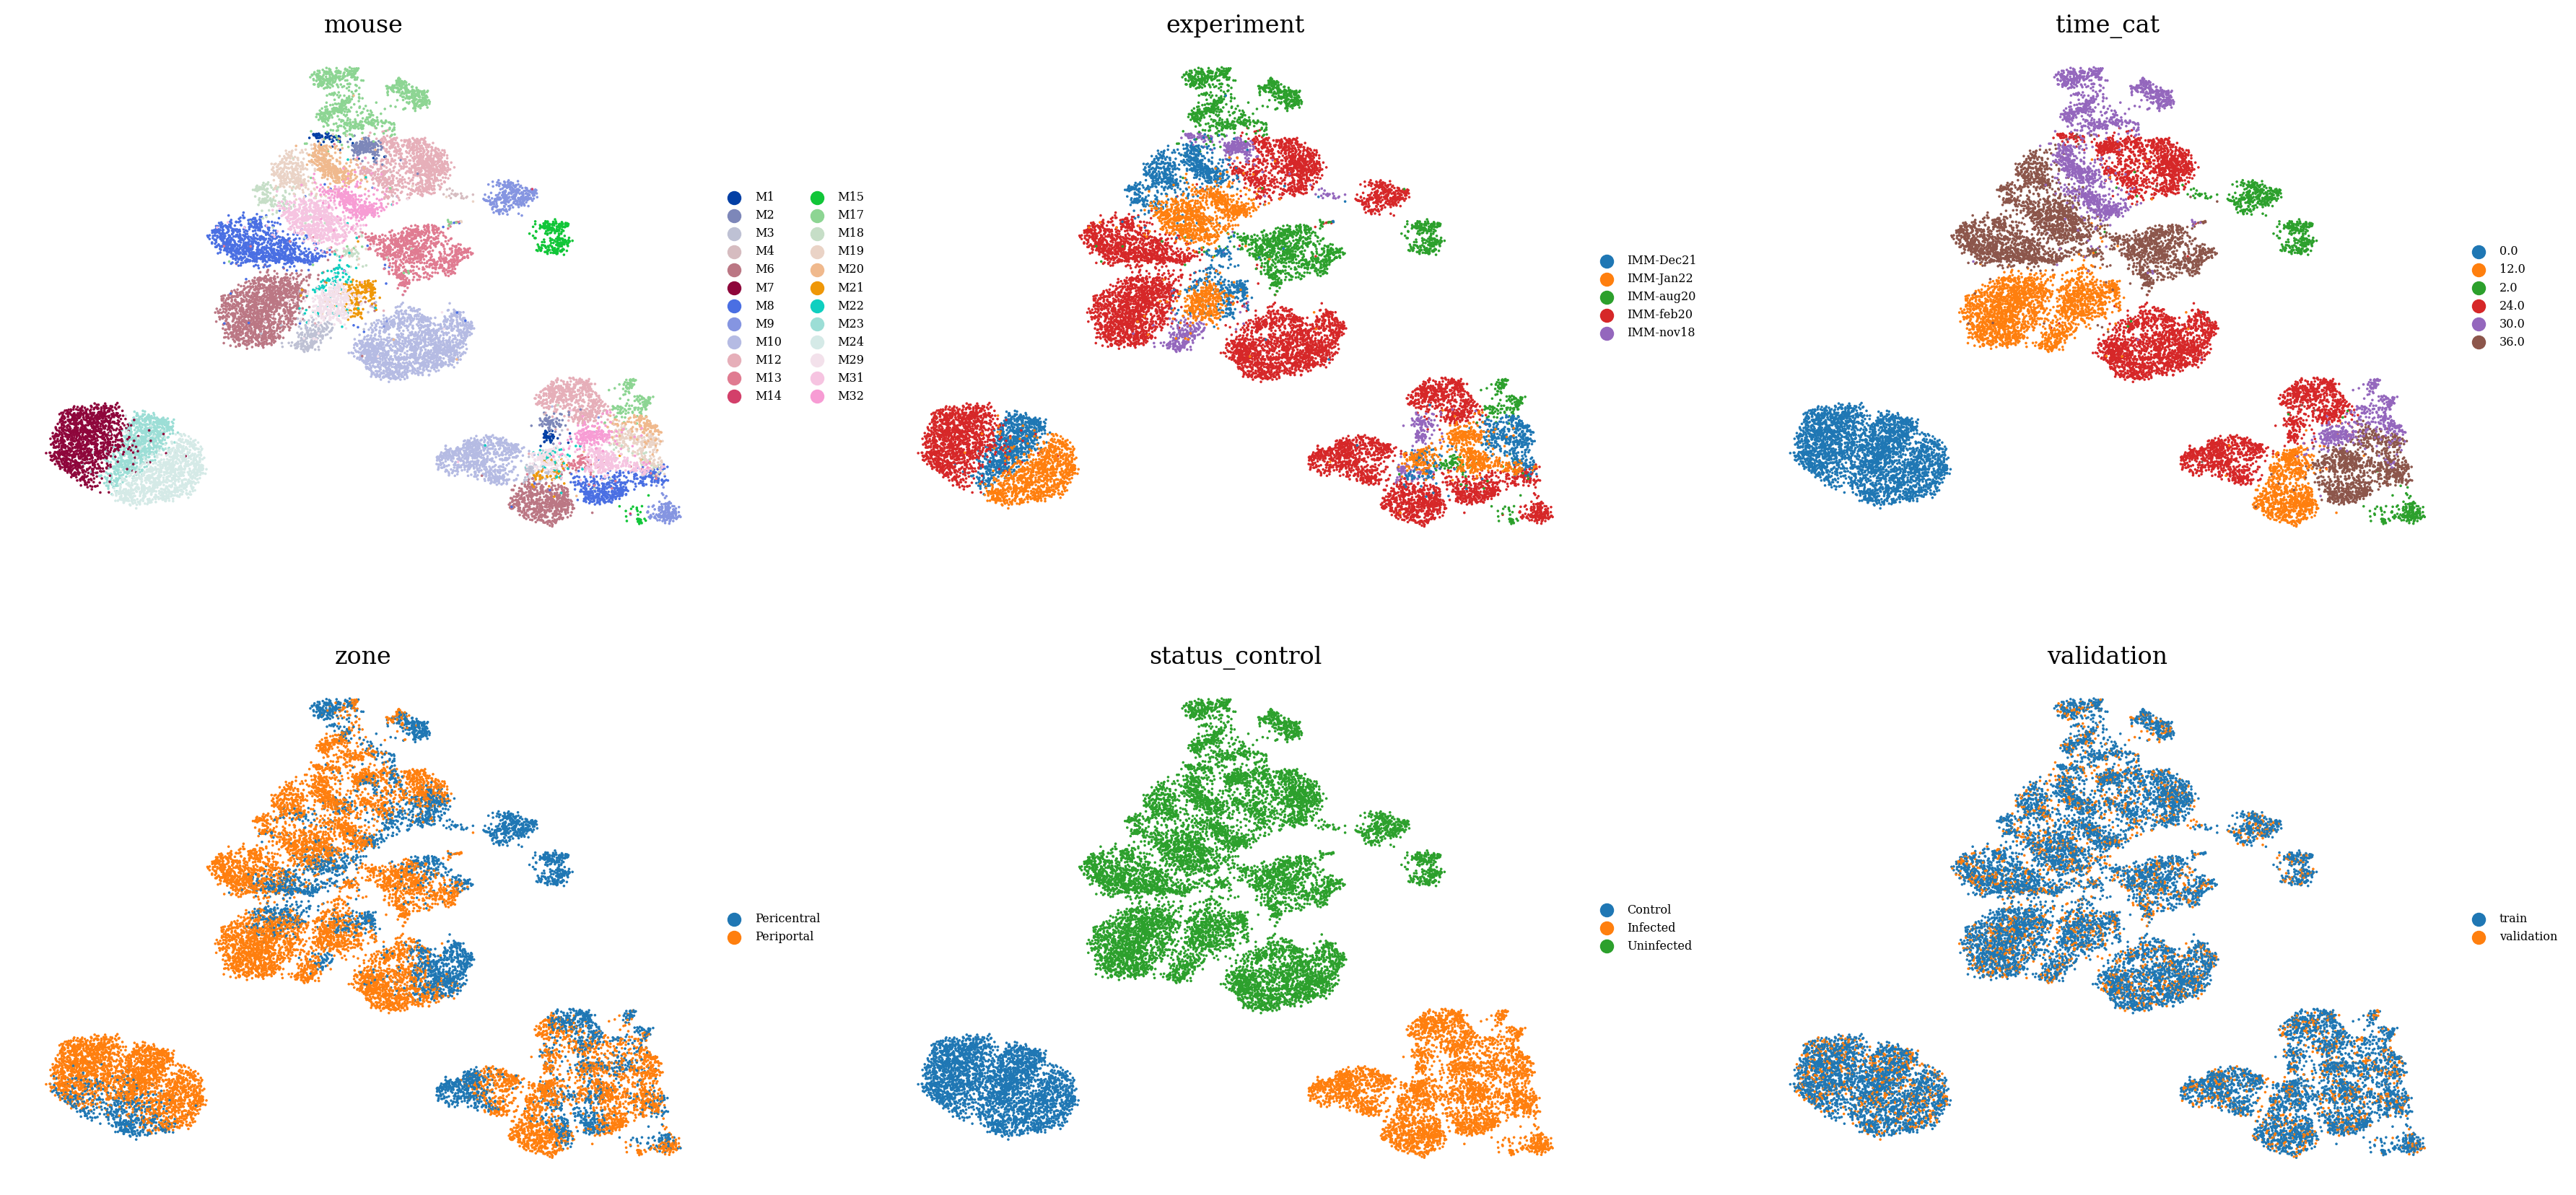

In [15]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

## Preds

In [16]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [17]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


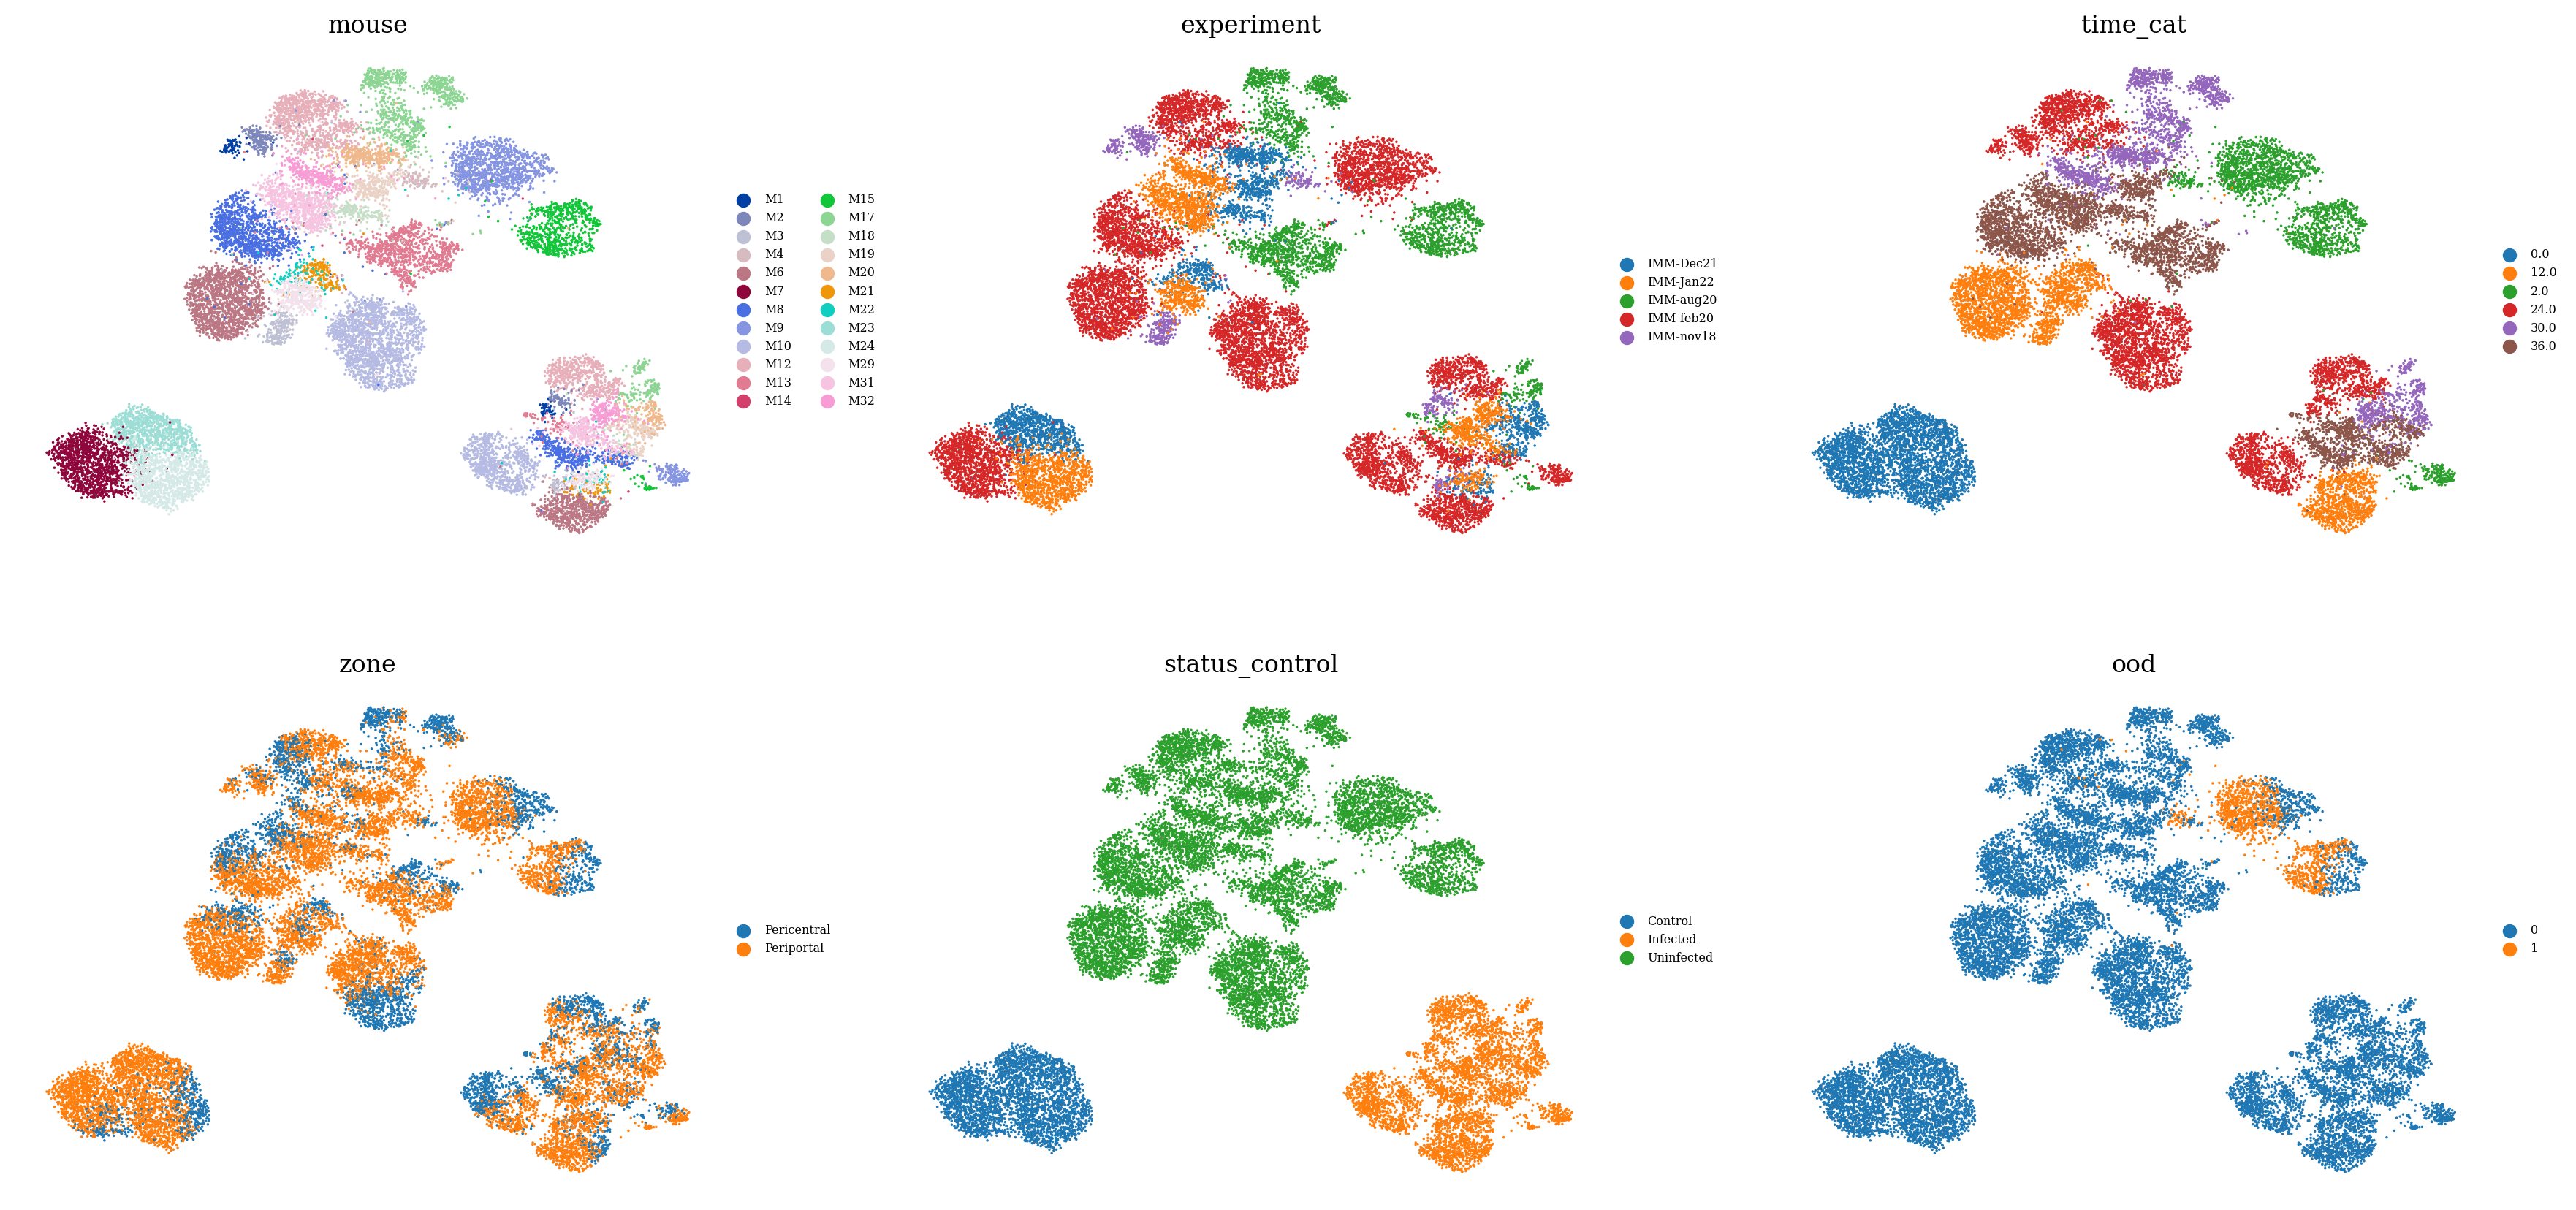

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "ood"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [19]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.45935023355901955
F1 Weighted: 0.45845070881559324



{'accuracy': 1.0,
 'precision_macro': 1.0,
 'recall_macro': 1.0,
 'f1_score_macro': 1.0,
 'precision_micro': 1.0,
 'recall_micro': 1.0,
 'f1_score_micro': 1.0,
 'precision_weighted': 1.0,
 'recall_weighted': 1.0,
 'f1_score_weighted': 1.0,
 'confusion_matrix': array([[1330]])}

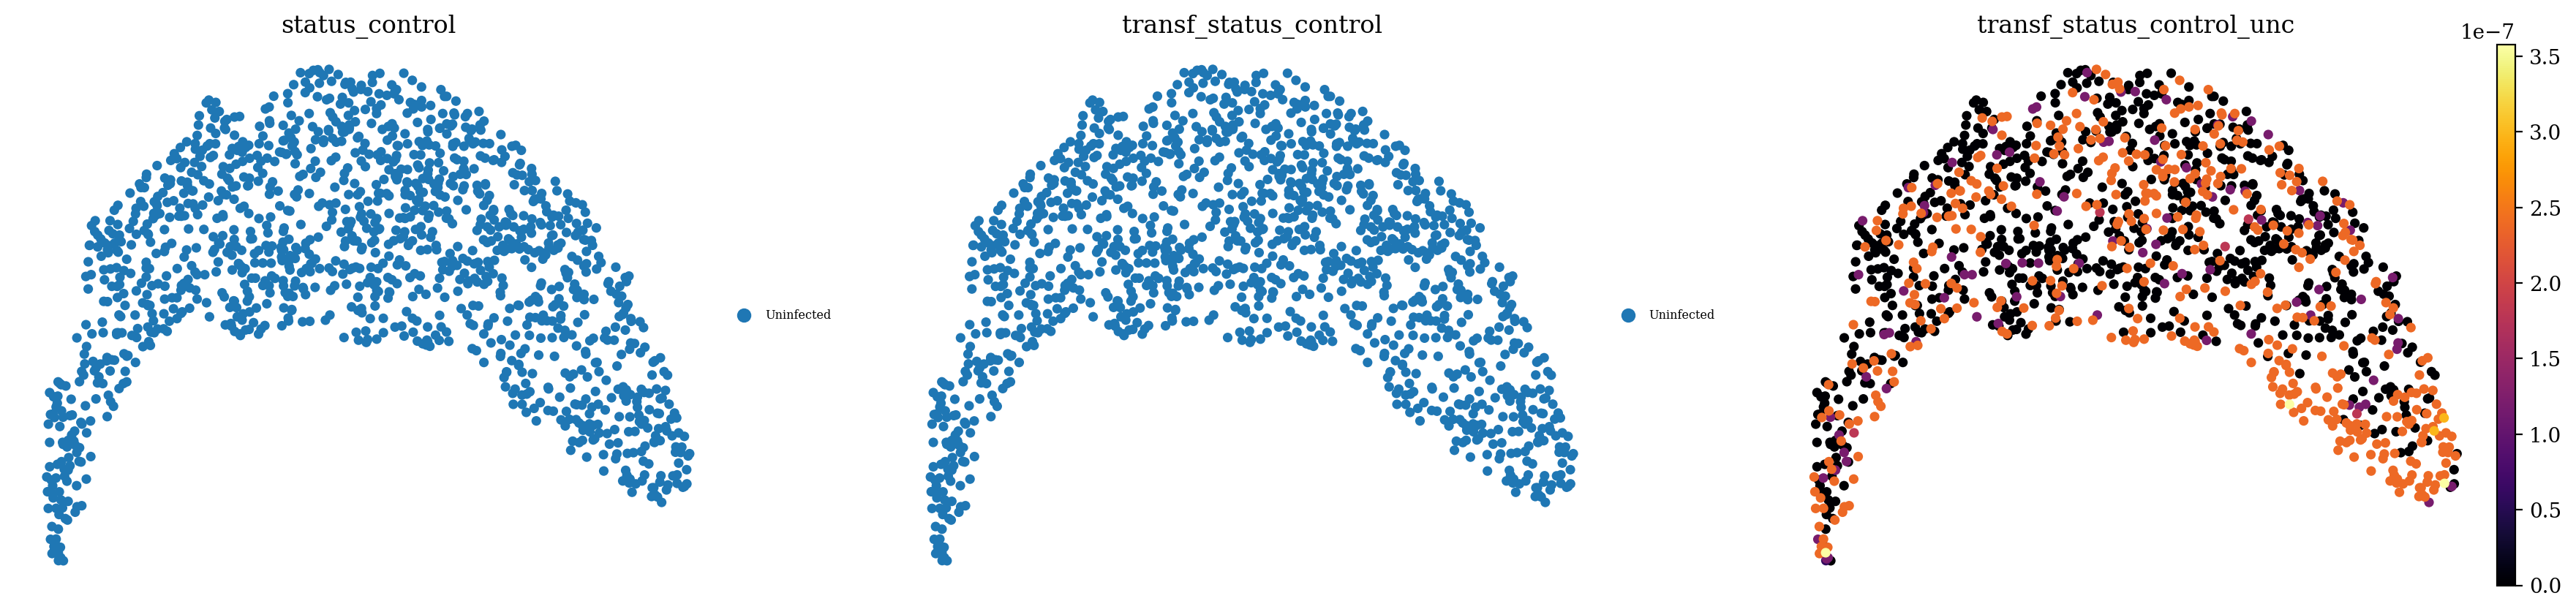

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )